In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

In [9]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text

from scipy.stats import ks_2samp, ttest_ind
from statsmodels.stats.multitest import multipletests

import scvi
from scvi.model import CondSCVI, DestVI

import umap
import torch
from torch.distributions import Gamma
import gseapy
import hotspot

from utils import *

%matplotlib inline

# import data and collide cell-types

In [10]:
sc_adata = sc.read_h5ad("scRNA-LN-compressed.h5ad")

In [11]:
sc_adata.obs["broad_cell_types"].value_counts()

B cells          8359
CD8 T cells      3268
CD4 T cells      2043
Tregs             390
Migratory DCs     299
Macrophages       105
cDC1s             100
NK cells           93
GD T cells         88
cDC2s              87
Monocytes          79
pDCs               78
Name: broad_cell_types, dtype: int64

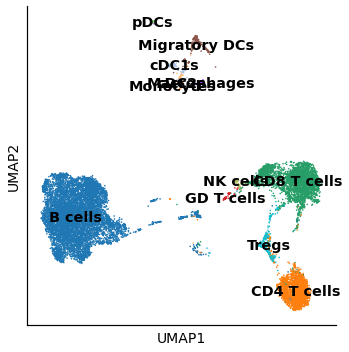

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(
    sc_adata, 
    color="broad_cell_types",
    frameon=True,
    title="",
    legend_loc="on data",
    legend_fontsize="x-large",
    ax=ax, size=10, show=False,
)
plt.tight_layout()
plt.savefig("figures/UMAP_scRNA.pdf", dpi=DPI)

In [13]:
sc_adata.obs["broad_cell_types"].value_counts().sum()

14989

## Filter some genes on scRNA

In [14]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


## get intersection with spatial

In [15]:
st_adata = sc.read_h5ad("ST-LN-compressed.h5ad")

In [16]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

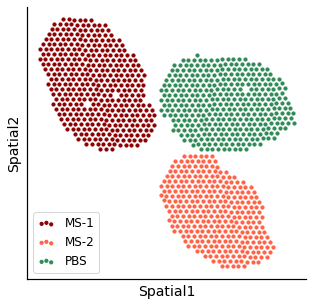

In [17]:
mapping_ln = {"TC": "MS-1", 
              "BD": "MS-2",
              "TD": "PBS"}
st_adata.obs["lymph_node"] = [mapping_ln[x] for x in st_adata.obs["LN"]]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
color_list = ["darkred", "tomato", "seagreen"]
name_list = ["MS-1", "MS-2", "PBS"]
for i, value in enumerate(["TC", "BD", "TD"]):
    mask = st_adata.obs["LN"] == value
    ax.scatter(st_adata.obsm["location"][mask, 0], st_adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=10)
ax.legend()
prettify_axis(ax, False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Spatial1")
ax.set_ylabel("Spatial2")
plt.savefig("figures/spatial.pdf", dpi=DPI)

In [18]:
st_adata.obs["LN"].value_counts()

TC    400
TD    369
BD    323
Name: LN, dtype: int64

## fit scRNA-seq model

In [19]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["broad_cell_types"]                                     
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14989 cells, 1888 vars, 1 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [113]:
train = False
if train:
    # train the conditional VAE
    sc_model = CondSCVI(sc_adata, weight_obs=True)
    sc_model.train(max_epochs=250)
    sc_model.history["elbo_train"].plot()
    sc_model.save("sc_model", overwrite=True)
else:
    sc_model = CondSCVI.load("sc_model", sc_adata, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14989 cells, 1888 vars, 1 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc_adata.obsm["X_CondSCVI"] = sc_model.get_latent_representation()

## Deconvolution

In [22]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [23]:
# get dataset ready
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1092 cells, 1888 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████| 2500/2500 [07:56<00:00,  5.25it/s, loss=1.91e+06, v_num=1]


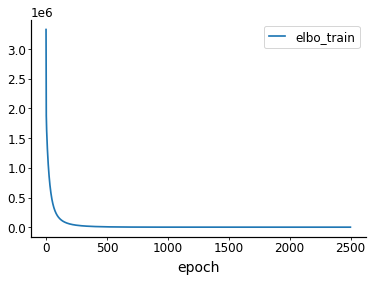

In [24]:
# add here number of cell type
train_st = True
if train_st:
    st_model = DestVI.from_rna_model(st_adata, sc_model, vamp_prior_p=100)
    st_model.train(max_epochs=2500, plan_kwargs={"lr":0.005})
    st_model.history["elbo_train"].plot()
    st_model.save("st_model", overwrite=True)
else:
    st_model = DestVI.load("st_model", st_adata)

In [26]:
st_adata.obsm["proportions"] = st_model.get_proportions()
gamma = st_model.get_gamma(return_numpy=True)

## Statistics on proportions

### Run hotspot to detect more spatially variable cell types

In [27]:
loc = pd.DataFrame(data=st_adata.obsm["location"], index=st_adata.obs.index)
hs = hotspot.Hotspot(st_adata.obsm["proportions"].T, model='none', latent=loc,)

hs.create_knn_graph(
    weighted_graph=True, n_neighbors=50,
)

hs_results = hs.compute_autocorrelations(jobs=4)

100%|██████████| 12/12 [00:00<00:00, 12.56it/s]


##  Show proportion for every cell type spatially and find characteristic proportions

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


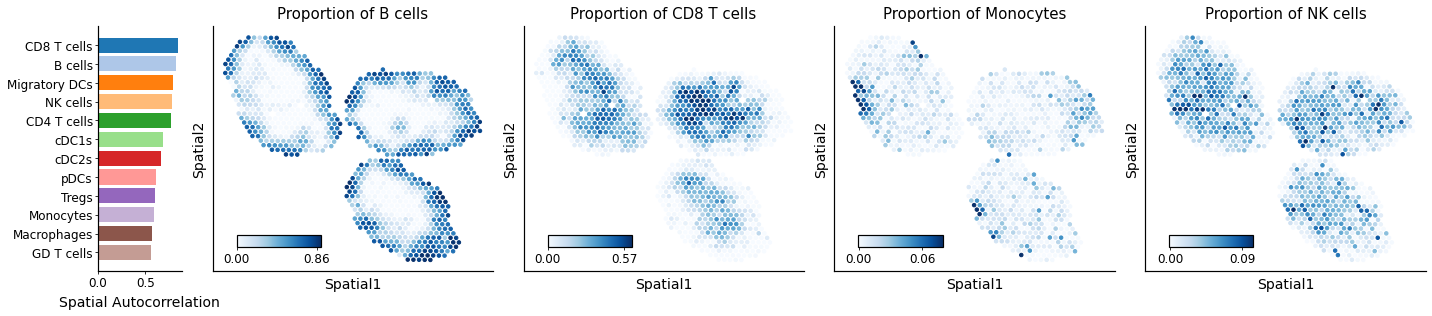

In [33]:
# selected cell type for paper
fig, axes = plt.subplots(1, 5, figsize=(20, 4.5), gridspec_kw={'width_ratios': [0.3, 1, 1, 1, 1]})
ct_list = [None, "B cells", "CD8 T cells", "Monocytes", "NK cells"]
prettify_axis(axes[0])
bar_data = hs_results.sort_values("C", ascending=True)
axes[0].barh(np.arange(bar_data.shape[0]), bar_data["C"].values, color=sns.color_palette("tab20")[0:bar_data.shape[0]][::-1])
axes[0].set_yticks(np.arange(bar_data.shape[0]))
axes[0].set_yticklabels( bar_data.index.values)
axes[0].set_xlabel("Spatial Autocorrelation")

for i in range(1, 5):
    prettify_axis(axes[i], False)
    data = st_adata.obsm["proportions"][ct_list[i]]
    vmax = np.quantile(data, 0.99)
    scplot = axes[i].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=data, s=12, cmap="Blues", vmax=vmax)
    
    a, b = np.quantile(data, 0.01),np.quantile(data, 0.99)
    ta, tb = ["{:0.2f}".format(x) for x in (a, b)]
    cax = inset_axes(axes[i], width="30%", height="5%", loc=3, borderpad=2) 
    cbar = plt.colorbar(scplot, cax=cax, orientation="horizontal")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    axes[i].set_title(F"Proportion of {ct_list[i]}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("Spatial1")
    axes[i].set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/proportions.pdf", dpi=DPI)

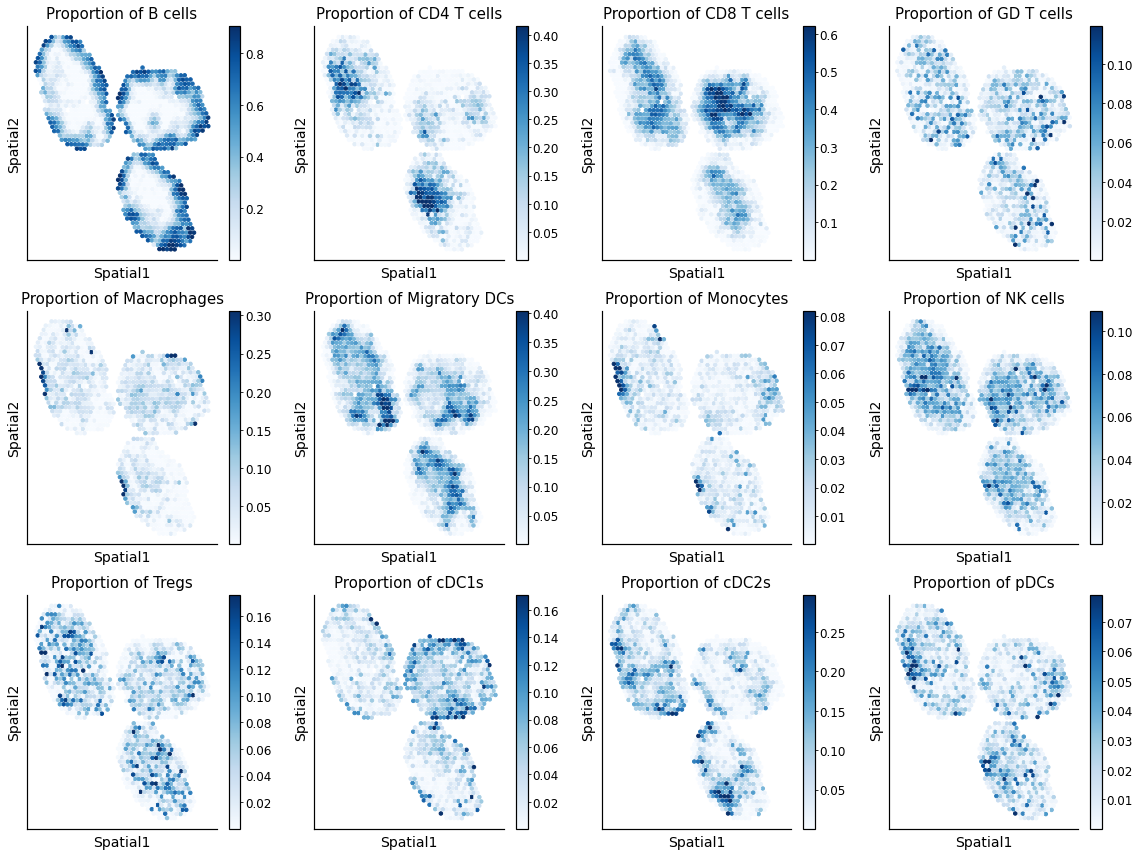

In [34]:
# all cell types for supplements
# selected cell type for paper
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
ct_list = st_adata.obsm["proportions"].columns
for i in range(3):
    for j in range(4):
        prettify_axis(axes[i, j], False)
        data = st_adata.obsm["proportions"][ct_list[i*4 + j]]
        vmax = np.quantile(data, 0.99)
        scplot = axes[i, j].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=data, s=12, cmap="Blues", vmax=vmax)
        plt.colorbar(scplot, ax=axes[i, j])
        axes[i, j].set_title(F"Proportion of {ct_list[i*4+j]}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel("Spatial1")
        axes[i, j].set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/proportions_supp.pdf", dpi=DPI)

100%|██████████| 100/100 [00:00<00:00, 14338.03it/s]

B cells ANALYSIS:


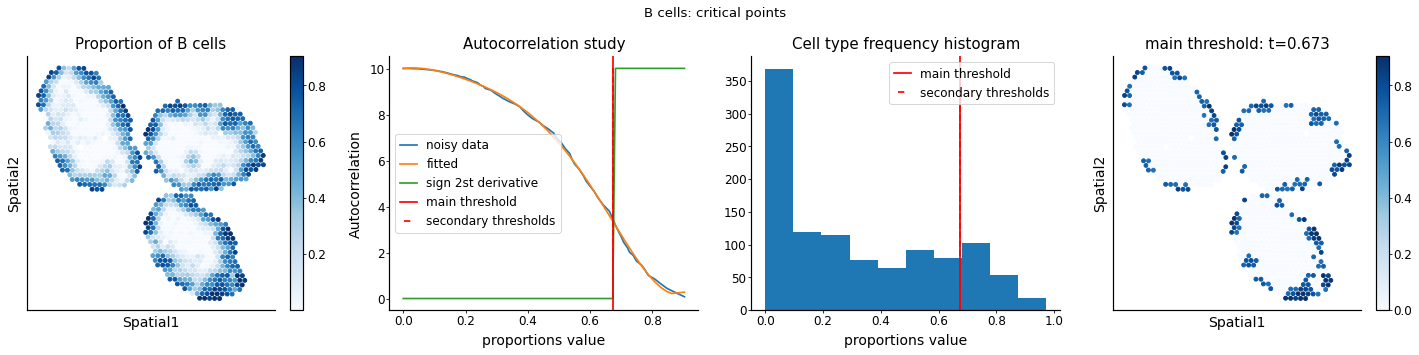

100%|██████████| 100/100 [00:00<00:00, 16323.42it/s]

CD4 T cells ANALYSIS:


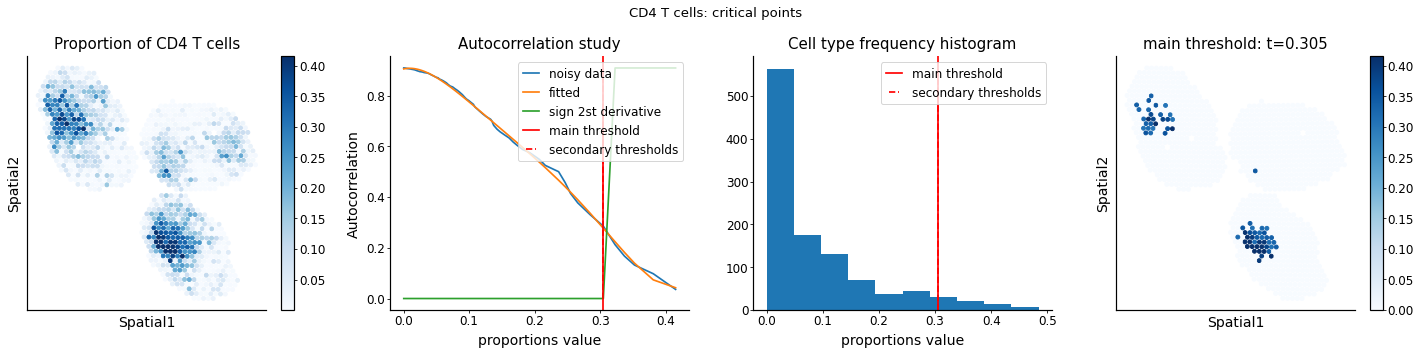

100%|██████████| 100/100 [00:00<00:00, 17729.65it/s]

CD8 T cells ANALYSIS:


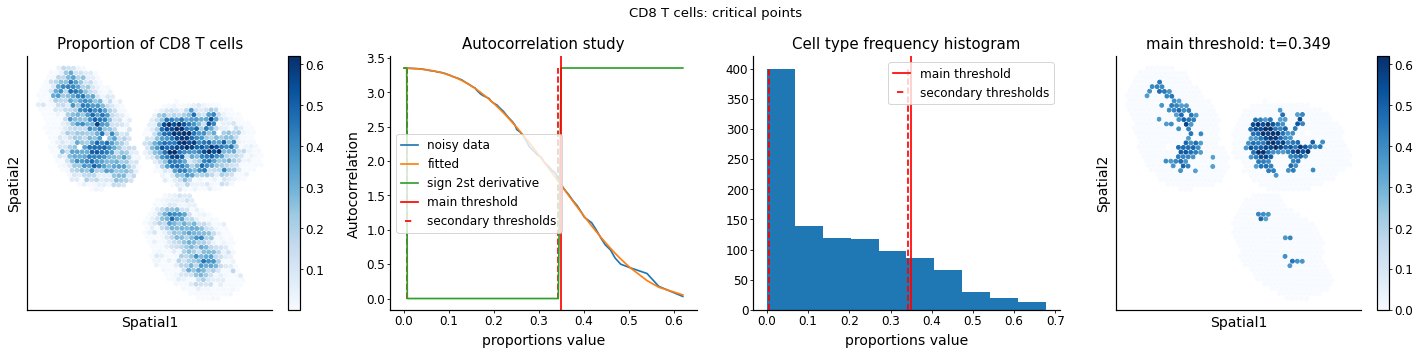

100%|██████████| 100/100 [00:00<00:00, 16937.79it/s]

GD T cells ANALYSIS:


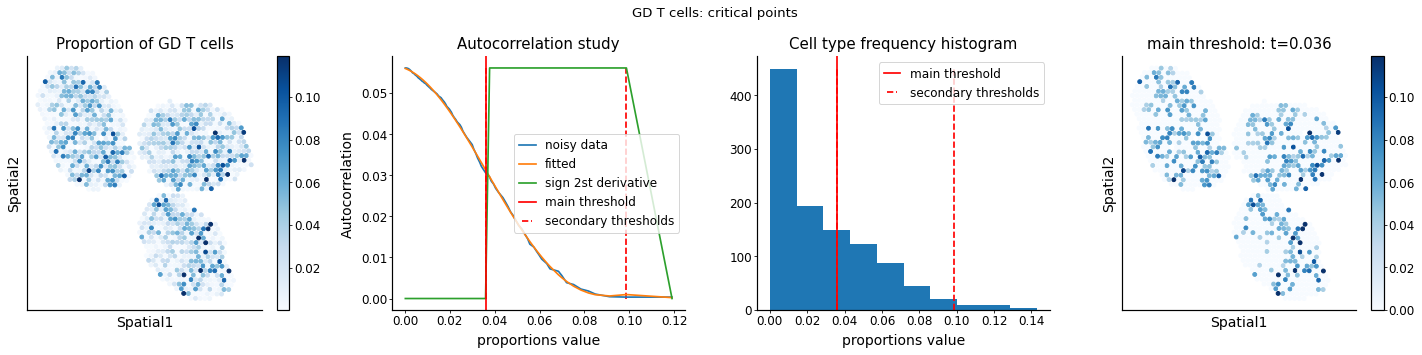

100%|██████████| 100/100 [00:00<00:00, 15047.37it/s]

Macrophages ANALYSIS:


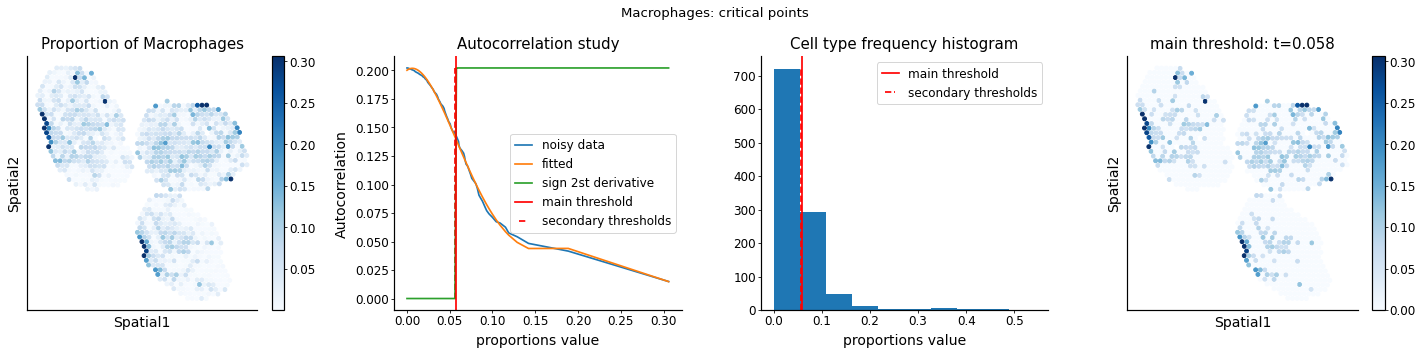

100%|██████████| 100/100 [00:00<00:00, 17296.10it/s]

Migratory DCs ANALYSIS:


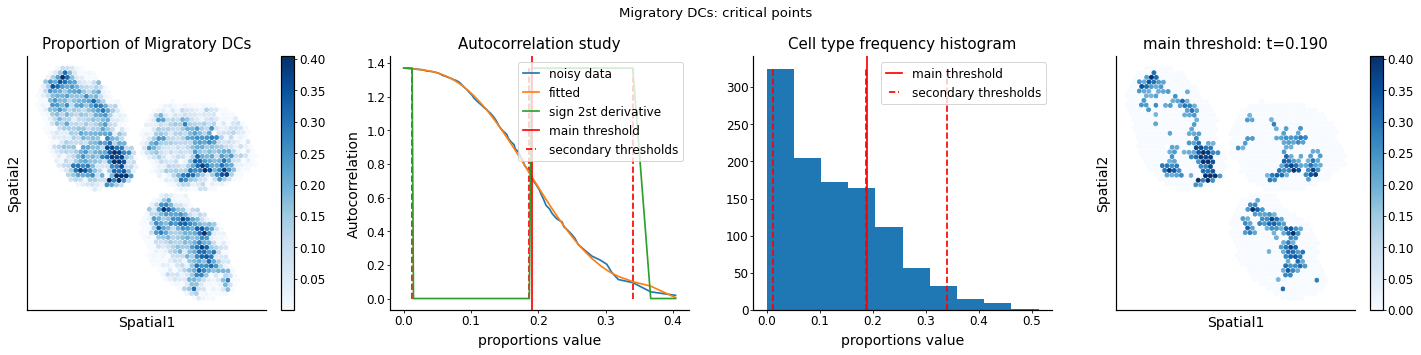

100%|██████████| 100/100 [00:00<00:00, 17196.11it/s]

Monocytes ANALYSIS:


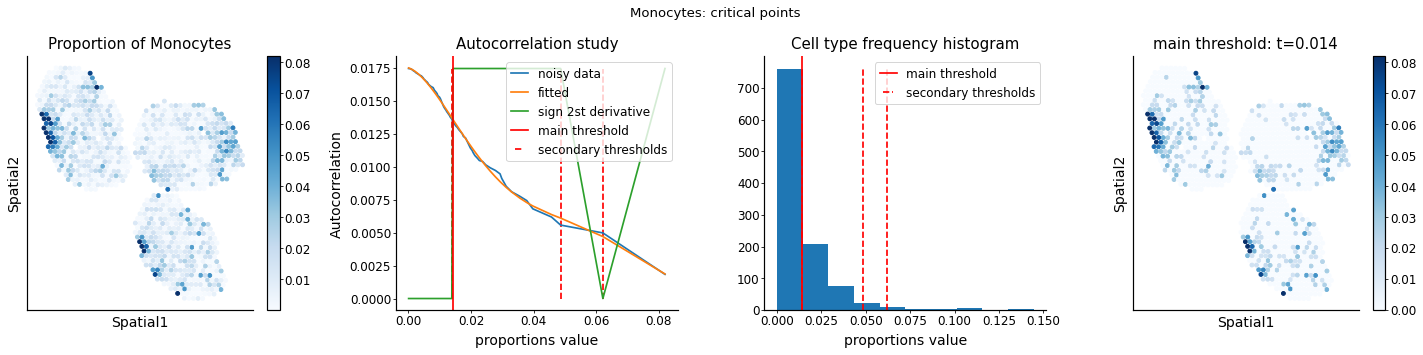

100%|██████████| 100/100 [00:00<00:00, 15061.42it/s]

NK cells ANALYSIS:


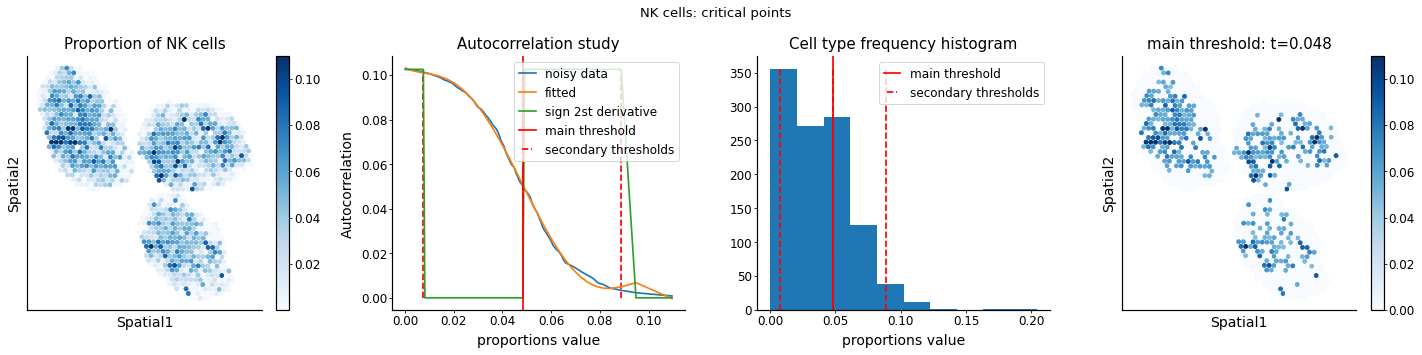

100%|██████████| 100/100 [00:00<00:00, 16546.23it/s]

Tregs ANALYSIS:


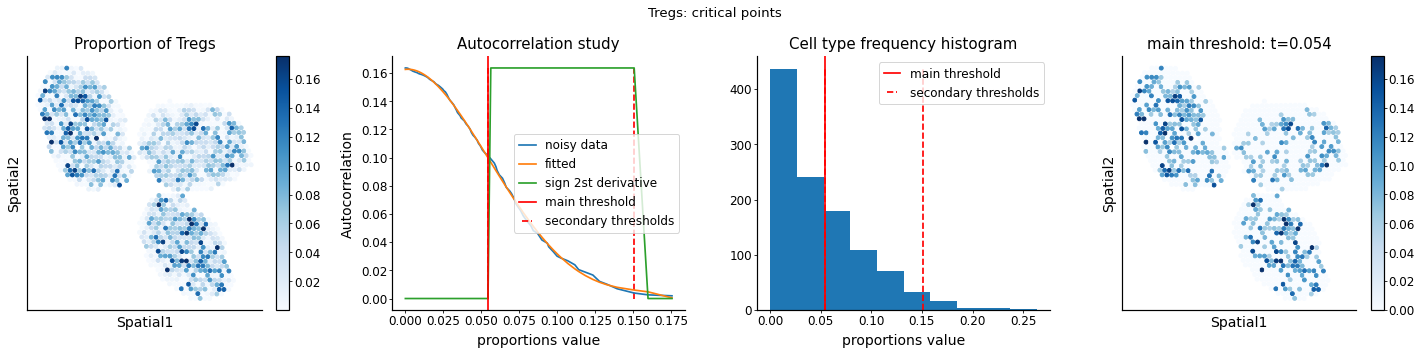

100%|██████████| 100/100 [00:00<00:00, 17369.88it/s]

cDC1s ANALYSIS:


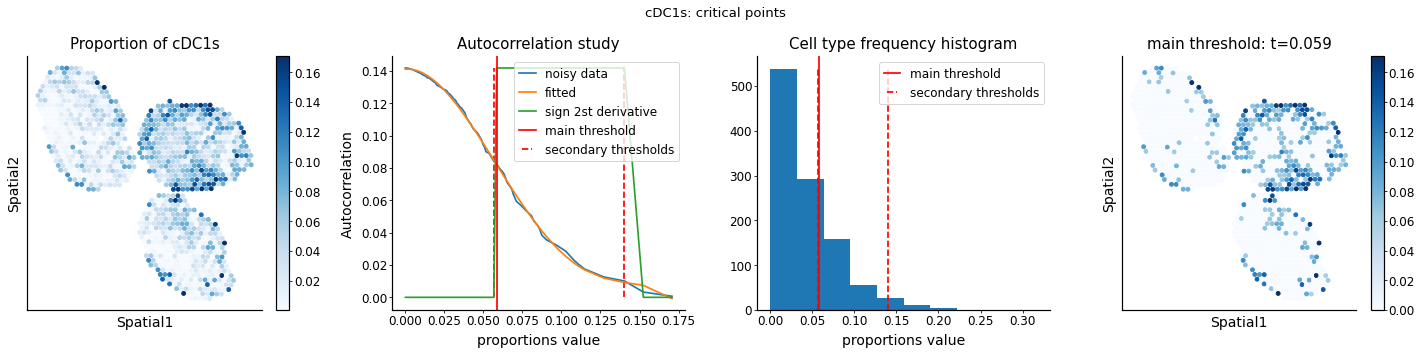

100%|██████████| 100/100 [00:00<00:00, 17036.17it/s]

cDC2s ANALYSIS:


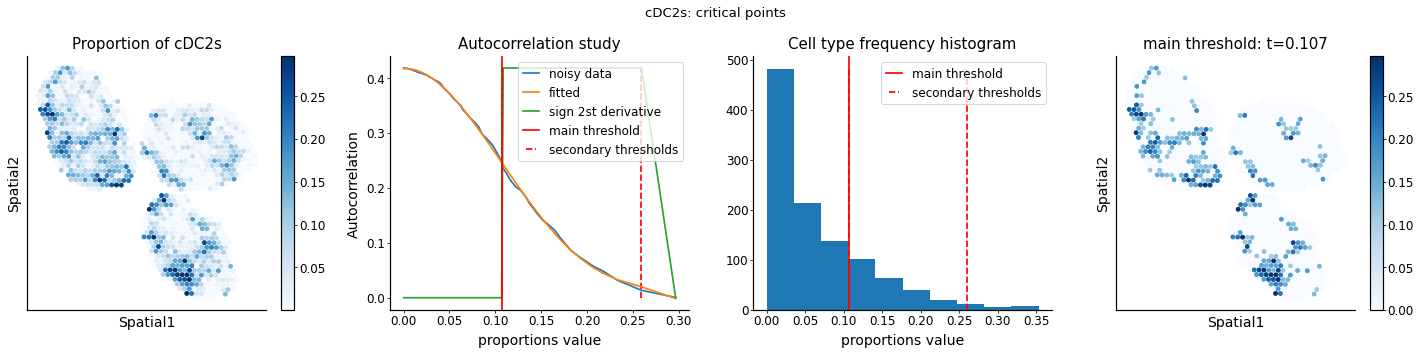

100%|██████████| 100/100 [00:00<00:00, 17482.82it/s]

pDCs ANALYSIS:


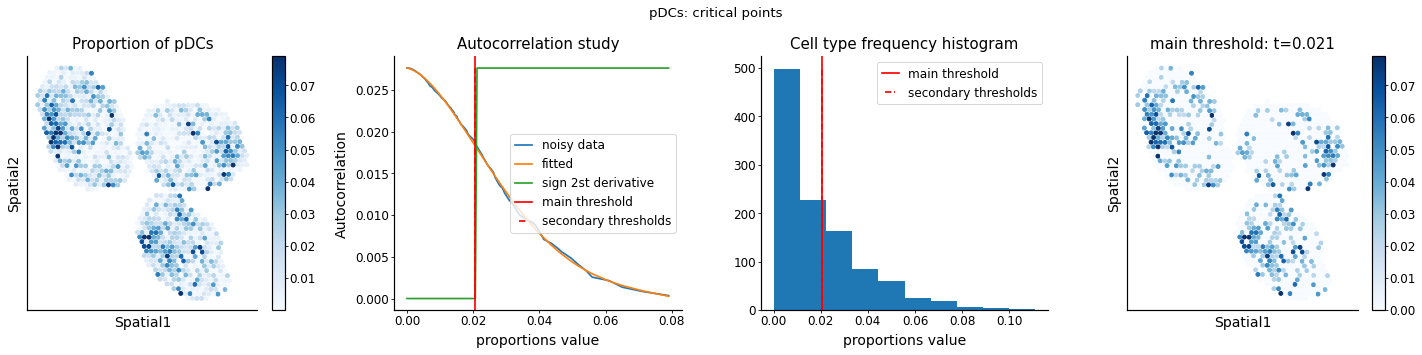

In [41]:
ct_thresholds = {}
nominal_threshold = {}
for name_ct in ct_list:
    # show proportions
    print(name_ct + " ANALYSIS:")
    array = st_adata.obsm["proportions"][name_ct]
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(name_ct+": critical points")
    ax1 = plt.subplot(141)
    prettify_axis(ax1, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=array, s=15, cmap="Blues", vmax=vmax)
    plt.colorbar()
    plt.title("Proportion of "+name_ct)

    # get characteristic values
    quantiles, stack = form_stacked_quantiles(array.values)
    index, z_values = get_autocorrelations(st_adata, stack, quantiles)
    z_values, smoothed, derivative, sign_2nd, _ = smooth_get_critical_points(index, z_values, s=0.1)

    #plot characteristic plots
    ymax = np.max(z_values)
    ax2 = plt.subplot(142)
    prettify_axis(ax2)
    plt.plot(index, z_values, label="noisy data")
    plt.plot(index, smoothed, label="fitted")
    plt.plot(index, ymax * sign_2nd, label="sign 2st derivative")
    # identify points
    ipoints = index[np.where(sign_2nd[:-1] != sign_2nd[1:])[0]]
    plt.vlines(ipoints, ymin=0, ymax=np.max(z_values), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    nom_map = index[np.argmin(derivative)]
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.ylabel("Autocorrelation")
    plt.xlabel("proportions value")
    plt.title("Autocorrelation study")
    plt.legend()
    
    # plot on top of histogram
    ax3 = plt.subplot(143)
    prettify_axis(ax3)
    n, bins, patches = plt.hist(array.values)
    plt.vlines(ipoints, ymin=0, ymax=np.max(n), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.xlabel("proportions value")
    plt.title("Cell type frequency histogram")
    plt.legend()
    
    # add thresholds to dict
    nominal_threshold[name_ct] = nom_map
    ct_thresholds[name_ct] = ipoints
    
    ax4 = plt.subplot(144)
    prettify_axis(ax4, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")    # show binarization for every ipoint
    p = nom_map
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=array.values * (array.values > p), s=15, cmap="Blues", vmax=vmax)
    plt.title("main threshold: t={:0.3f}".format(p))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [ ]:
# from left to right for every LN:
# 1. spatial location of thresholded value, 2. number of spots, 
# 3. reached auto-correlation, 4. normalized histogram

In [42]:
ct_profile = st_adata.obsm["proportions"].copy()
ct_profile["LN"] = st_adata.obs["LN"]

100%|██████████| 12/12 [00:00<00:00, 15763.12it/s]


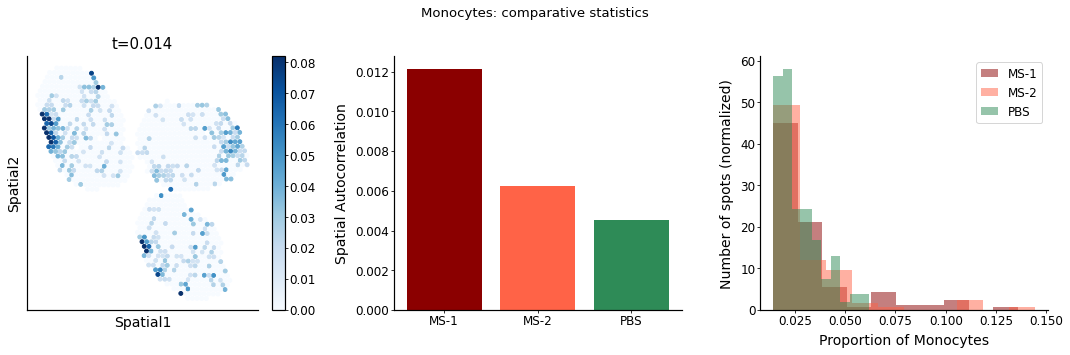

In [50]:
name_ct = "Monocytes"

labels=["TC", "BD", "TD"]
name_list = ["MS-1", "MS-2", "PBS"]
color_list = ["darkred", "tomato", "seagreen"]

fig = plt.figure(figsize=(15, 5))
fig.suptitle(name_ct+": comparative statistics")

# 1. spatial location of thresholded value
ax1 = plt.subplot(131)
prettify_axis(ax1, False)
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
array = ct_profile[name_ct]
vmax = np.quantile(array.values, 0.99)
p = nominal_threshold[name_ct]
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                    c=array.values * (array.values > p), s=15, cmap="Blues", vmax=vmax)
plt.colorbar()
plt.title("t={:0.3f}".format(p))
        
ax2 = plt.subplot(132)

z_values = []
for i in range(3):
    mask = st_adata.obs["LN"] == labels[i]
    loc = pd.DataFrame(data=st_adata.obsm["location"][mask], index=st_adata.obs.index[mask])
    matrix = st_adata.obsm["proportions"][mask].values.T 
    matrix = matrix * (matrix > p)
    df = pd.DataFrame(data=matrix, 
                      columns=st_adata.obs.index[mask], index=st_adata.obsm["proportions"].columns)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=10,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)
    z_values.append(hs_results["Z"][name_ct])
plt.bar([0, 1, 2], z_values, color=color_list)
plt.xticks([0, 1, 2], labels=name_list)
plt.ylabel("Spatial Autocorrelation")

ax4=plt.subplot(133)
for i in range(3):
    array_ln = ct_profile[ct_profile["LN"] == labels[i]][name_ct]
    plt.hist(array_ln[array_ln > p], label=name_list[i], alpha=0.5, density=True, color=color_list[i])
plt.legend()
plt.xlabel(f"Proportion of {name_ct}")
plt.ylabel("Number of spots (normalized)")
plt.tight_layout()
plt.show()

100%|██████████| 12/12 [00:00<00:00, 14812.14it/s]


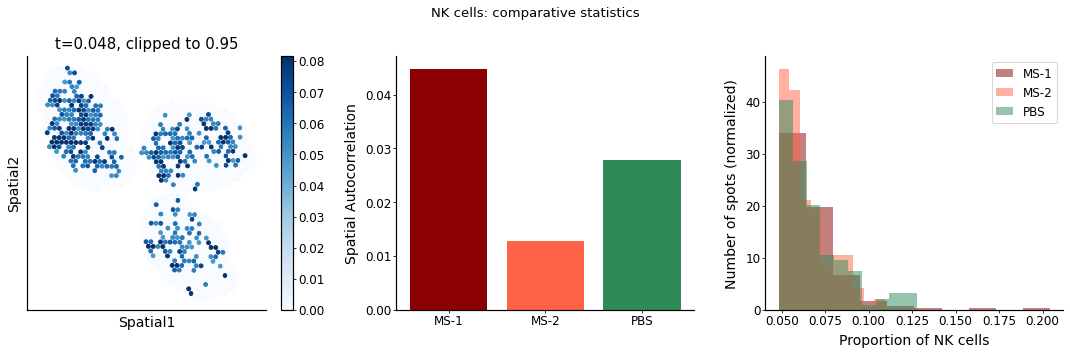

In [51]:
name_ct = "NK cells"

labels=["TC", "BD", "TD"]
name_list = ["MS-1", "MS-2", "PBS"]
color_list = ["darkred", "tomato", "seagreen"]

fig = plt.figure(figsize=(15, 5))
fig.suptitle(name_ct+": comparative statistics")

# 1. spatial location of thresholded value
ax1 = plt.subplot(131)
prettify_axis(ax1, False)
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
array = ct_profile[name_ct]
vmax = np.quantile(array.values, 0.95)
p = nominal_threshold[name_ct]
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                    c=array.values * (array.values > p), s=15, cmap="Blues", vmax=vmax)
plt.colorbar()
plt.title("t={:0.3f}, clipped to 0.95".format(p))
        
ax2 = plt.subplot(132)

z_values = []
for i in range(3):
    mask = st_adata.obs["LN"] == labels[i]
    loc = pd.DataFrame(data=st_adata.obsm["location"][mask], index=st_adata.obs.index[mask])
    matrix = st_adata.obsm["proportions"][mask].values.T 
    matrix = matrix * (matrix > p)
    df = pd.DataFrame(data=matrix, 
                      columns=st_adata.obs.index[mask], index=st_adata.obsm["proportions"].columns)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=10,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)
    z_values.append(hs_results["Z"][name_ct])
plt.bar([0, 1, 2], z_values, color=color_list)
plt.xticks([0, 1, 2], labels=name_list)
plt.ylabel("Spatial Autocorrelation")

ax4=plt.subplot(133)
for i in range(3):
    array_ln = ct_profile[ct_profile["LN"] == labels[i]][name_ct]
    plt.hist(array_ln[array_ln > p], label=name_list[i], alpha=0.5, density=True, color=color_list[i])
plt.legend()
plt.xlabel(f"Proportion of {name_ct}")
plt.ylabel("Number of spots (normalized)")
plt.tight_layout()
plt.show()

... storing 'lymph_node' as categorical


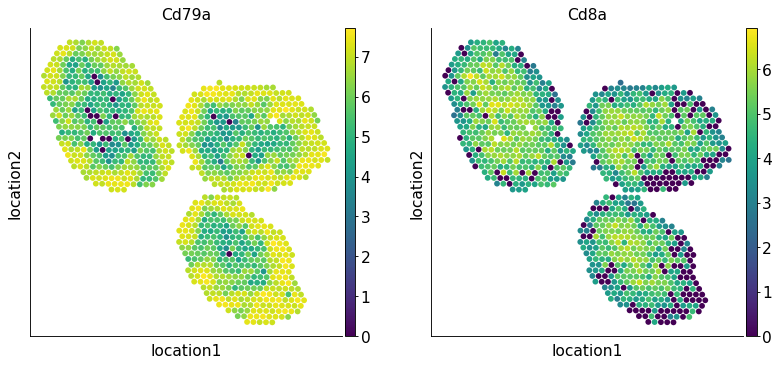

In [52]:
sc.set_figure_params(figsize=(5, 5))
sc.pl.embedding(st_adata, "location", color=["Cd79a", "Cd8a"])
plt.show()

### Now, for every cell type, we wish to explore the gamma space
1. find the spatially principal axis of the gamma space
2. project the spatial data onto them
3. display associated genes with hotspot


B cells ANALYSIS:


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


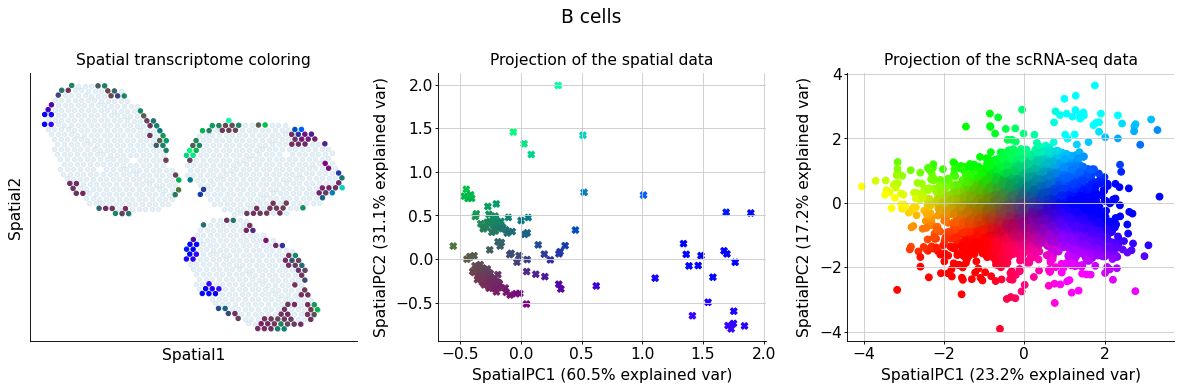



Component:0


/home/ubuntu/destVI-paper-code/lymph_node/deconvolution/utils.py:135: RuntimeWarning: invalid value encountered in true_divide
  return r



top
Tnnt2, Itga8, Sirpb1c, Mertk, Met, Scn3a, Cd300lb, Mfsd7a, Spint1, Ptprm, Ace, Mmp12, Hpn, Syndig1l, Ear2, Tarm1, Pilrb1, Clec1b, Hcar2, Ankrd35, Ppp1r3d, Cldn1, Trem2, Mab21l3, Ifit3, Irf7, Rtp4, Ifit3b, Slfn5, Usp18, Oasl2, Ifit1, Zbp1, Stat1, Ifit2, Ifi27l2a, Rsad2, Ifi47, Oas3, Igtp, Serpina3g, Isg15, Parp14, Trim30a, Cd79a, Isg20, Cmpk2, Ifitm3, Cd74, Gbp4

Interferon alpha/beta signaling, Interferon signaling, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Immune system, Antiviral mechanism by interferon-stimulated genes, Interferon-gamma signaling pathway, Type II interferon signaling (interferon-gamma), Interferon alpha signaling regulation, Dilated cardiomyopathy, Nectin adhesion pathway

bottom
Ncl, Cd83, Nr4a1, Ddx21, Rel, Kdm6b, Dennd4a, Gm26532, Bcl2a1b, Gnl3, Ppp1r14b, Srm, Marcks, Nme1, Hspa9, Ccnd2, Npm1, Set, Canx, Hspa4, Eprs, Odc1, Hnrnpab, Eif4a1, Cdv3, Gar1, Nolc1, Apex1, Bzw2, Mettl1, Mybbp1a, Junb, Timm8a1, Eif3b, Dctpp

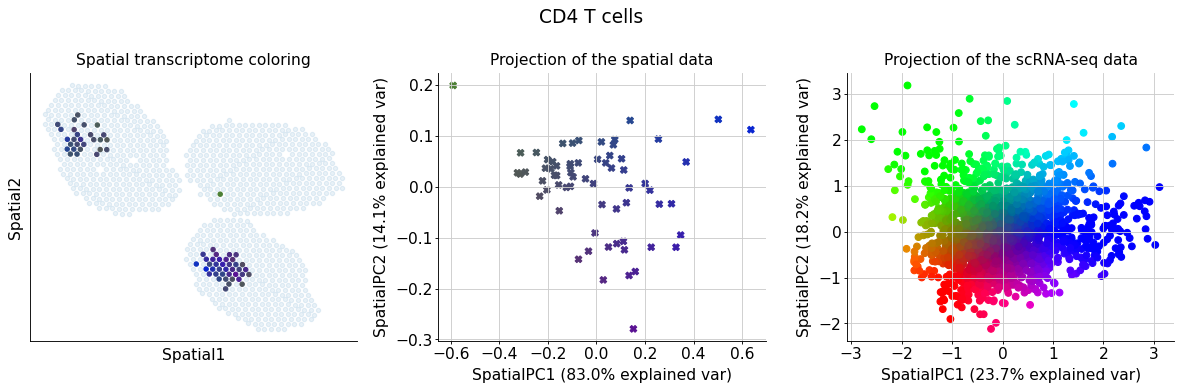



Component:0

top
Ear2, Fzd1, Fmnl2, Mmp12, Ffar4, Spint1, Fcor, Fcgr4, Spp1, Fcgr1, Spry2, Fads3, F630028O10Rik, F10, Mrc1, Etl4, Erbb2, Mgst1, Galnt3, Ptprm, Gas7, Plcb1, Gm6377, Gm5150, Gm13710, Met, Gfra2, Rab44, Metrnl, Smyd1, Mfsd7a, Sned1, Gcsam, Rab38, Mgl2, Sox13, Stab2, Epha2, Ckap2l, Tgm1, Thbd, Cpne8, Mylk, Cox6a2, Cmklr1, Cma1, Clec9a, Clec4g, Clec4e, Clec4d

FGF signaling pathway, Coagulation common pathway, Adherens junction cell adhesion, PKC-catalyzed phosphorylation of inhibitory phosphoprotein of myosin phosphatase, Sema4D in semaphorin signaling, Focal adhesion, Fibrin clot formation (clotting cascade), Arf6 signal transduction regulation, p53 signaling pathway, Alpha-6 beta-1 and alpha-6 beta-4 integrin signaling

bottom
Rps2, Rps12, Rpsa, Rpl41, Rplp0, Npm1, Rplp1, Tmsb4x, Chchd10, Set, Hnrnpa1, Cd3g, Tcf7, Mxd4, Nme1, Slc25a4, Ybx1, Hmgb1, Trat1, Rgs10, Mif, Tnfrsf9, Thy1, Ppia, Themis, Ckb, Gapdh, Atp1b1, Mcm7, Dut, Rgcc, Nap1l1, Spint2, Tubb5, Ptma, Rbbp7, Cd3

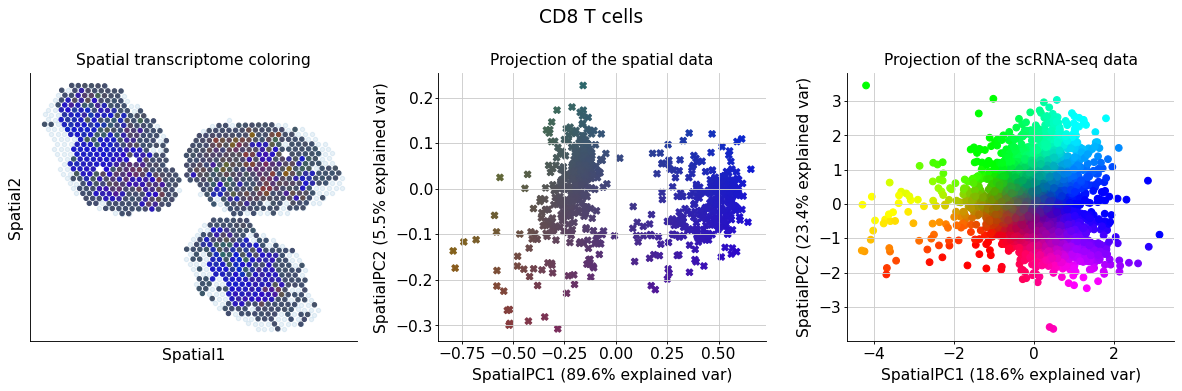



Component:0

top
Chil3, Lrp1, Met, Mertk, Mefv, Crispld2, Mab21l3, M1ap, Lrrc25, Lmo7, Clec9a, Sned1, Lipc, Klra17, Klk1b27, Ehf, Klk1, Spic, Mfsd7a, Clec4g, Nid2, Gpr141, Cd59a, Ttc39a, Ncam1, Ms4a8a, Ms4a7, Cebpa, Cfh, Mrc1, Clec4e, Cldn1, Mmp12, Clec1a, Treml4, Clec1b, Clec4a2, Clec4d, Epha2, Etl4, Itgb5, Thbs1, Htr7, Syndig1l, Tarm1, Hcar2, Gcsam, Havcr1, Hap1, Gramd2

Urokinase-type plasminogen activator (uPA) and uPAR-mediated signaling, Malaria, Statin pathway, Arf6 signal transduction regulation, EGFR1 pathway, Phagosome, FGF signaling pathway, Retinoblastoma protein regulation, Adherens junction cell adhesion, Antigen processing: cross presentation

bottom
Ptma, Ppia, Lad1, Ccr9, Tnfrsf9, Fabp5, Utf1, Srm, Bcat1, Eif5a, Cdca7, Shmt1, Mettl1, Hsp90ab1, Nefh, Atad3a, Ramp1, Eif4a1, Marcksl1, Cd83, Hivep3, Rgcc, Timm8a1, Apex1, Gnl3, Nop58, Mpp6, Ddx39, Dctpp1, Cyp51, Ppp1r14b, Shmt2, Mrto4, Ranbp1, Nolc1, Pa2g4, Cct3, C1qbp, Ftsj3, Set, Spire1, Prmt1, Nop16, Mrpl12, Tnfrsf4, I

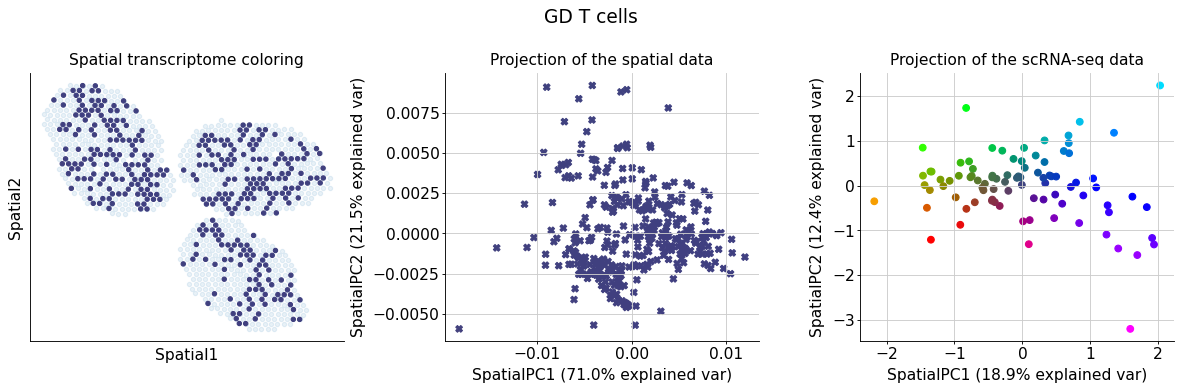



Component:0

top
Mcemp1, Rtn1, Efna2, Kif22, Ear2, Eaf2, E2f8, Mcm10, Dusp9, Kif2c, Kif5a, Klk1, Klra1, Dscc1, Rsad2, Dram1, Dqx1, Kif20a, Klra17, Dntt, Dnph1, Dnm3, Dnah2, Dna2, Sapcd2, Depdc1b, Depdc1a, Mzb1, Myof, Scin, Scn3a, Klra2, Efnb3, Rnd3, Dclk1, F10, Rab3il1, Fblim1, Kif14, Fam83d, Fam20c, Fam149a, Fads3, Rad51ap1, Rad54b, Rad54l, Rai14, Fabp4, F630028O10Rik, F13a1

Kinesins, MHC class II antigen presentation, Factors involved in megakaryocyte development and platelet production, Coagulation common pathway, Hemostasis pathway, Blood clotting cascade, DNA replication, Homologous recombination, Fibrin clot formation (clotting cascade), Aurora B signaling

bottom
Trdc, Blk, Itm2b, Actn2, Cd3g, Cd3e, Igtp, 5830411N06Rik, Ifngr1, Bcl11b, Itgae, Gbp2, Maf, Lat, Ccr2, Abi3bp, Sox13, Srgn, Ly6a, Oas3, Mmp25, Tmem176b, Cryba4, Pdia3, Tmem176a, Arhgap31, Glrx, Plxnd1, Pfkp, Crip1, Acsbg1, Rora, Cd247, Thy1, Lrrc25, Stat1, Lsp1, Aprt, Cd3d, Psap, Gbp5, Cxcr6, Serpinb1a, Zbp1, Cd48, A

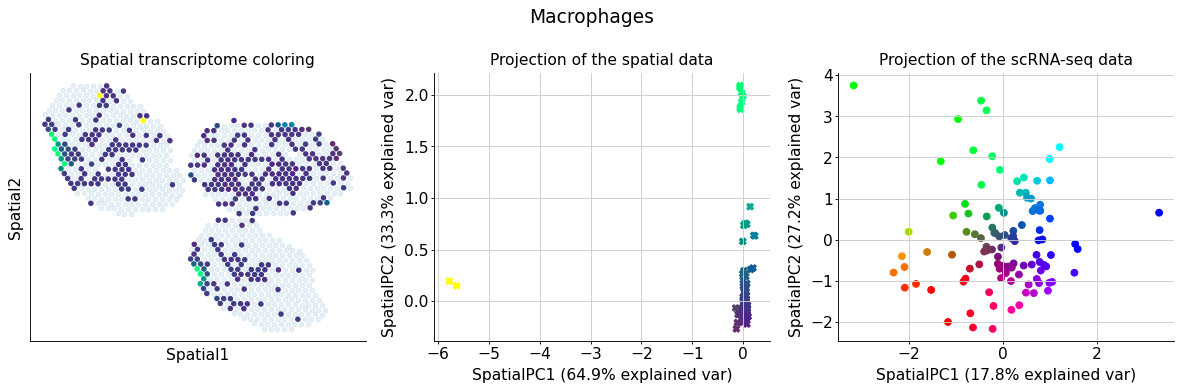



Component:0

top
Nuggc, Klrb1a, Sox5, Prg4, Ifitm6, Prg2, Dll1, Dkkl1, Depdc1b, Prf1, Klra9, Ddr1, Eno2, Klrb1b, Dbn1, Klrb1c, Dapl1, Gzma, Spp1, Klrc1, Spry2, Klrc2, Dnm3, Sox13, Klra8, Dqx1, Emilin2, Eme1, Efnb3, Efna2, Ecm1, Smpdl3b, Smtn, Smyd1, Snai1, Klra4, Ear2, Klra6, Dusp9, Klra7, Dusp4, Snx22, Dtx1, Ifng, Dscam, Gzmb, Gzmc, Cxcr3, Lad1, Hopx

Granzyme A-mediated apoptosis pathway, Graft-versus-host disease, Natural killer cell-mediated cytotoxicity, Allograft rejection, Type 1 diabetes mellitus, Interleukin-12/STAT4 pathway, MAP kinase pathway regulation through dual specificity phosphatases, D4-GDI signaling pathway, CTL mediated immune response against target cells, EGFR1 pathway

bottom
Top2a, Hmgb2, Lmnb1, Cep55, Mki67, Birc5, Nusap1, Tmpo, Kif11, Cdk1, H2afx, Spc25, Ube2c, Cenpe, Cbx5, Rrm2, Prc1, Aurka, Ccna2, Cks2, Bub1, Ccnb1, Tpx2, Hmgb1, Tlr2, Stmn1, Kif4, Cdca3, Ube2s, Tk1, Pbk, Mis18bp1, Esco2, Knstrn, Ly6i, Atad2, Spc24, Tubb4b, Snrpd1, Tuba1b, Pf4, Ect2, Ccdc3

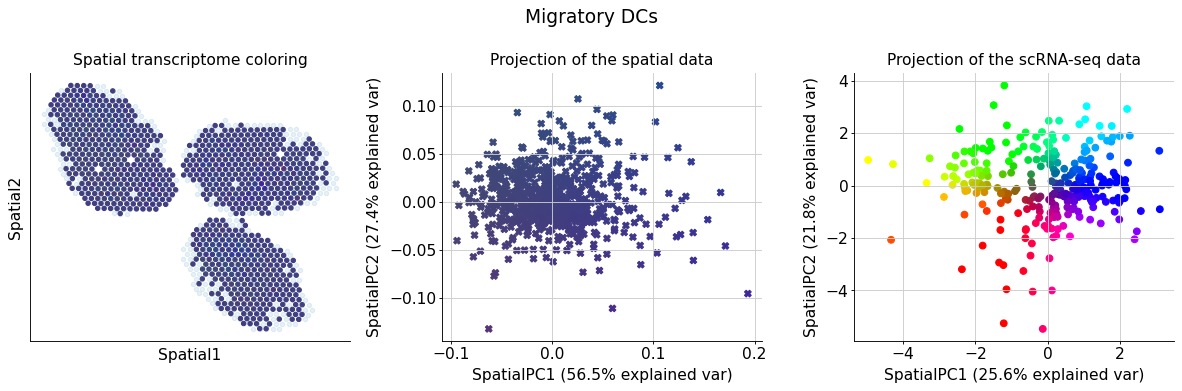



Component:0

top
Rassf6, Hist1h3c, Sirpb1c, Ncr1, Cd59a, Cd5l, Hcar2, Havcr1, Ptprm, Gzmc, Cd93, Cdh5, Pdcd1, Gzmb, Gzma, Cfh, Chdh, Neb, Chil3, Chl1, Gpsm2, Tnfsf11, Hlf, Troap, Penk, Ifitm10, Serpinb8, Trem2, Rab44, Serpine2, Trav3-3, Pgam2, Serpinf1, Rab3il1, Hpn, Hp, Ccr1, Ccr10, Ccr2, Ccr4, Siglec1, Cd163l1, Cd209a, Cd300lb, Parpbp, Clec10a, Gm8251, Gm5150, Fcgr4, Fcgr3

G alpha (i) signaling events, Binding of chemokines to chemokine receptors, Peptide G-protein coupled receptors, Cell adhesion molecules (CAMs), Granzyme A-mediated apoptosis pathway, Cytokine-cytokine receptor interaction, GPCR ligand binding, RANKL regulation of apoptosis and immune response, Chemokine signaling pathway, Selective expression of chemokine receptors during T-cell polarization

bottom
Malat1, Neat1, Plce1, Lifr, Vegfa, C4b, Birc2, Xcr1, Rab7b, Slc7a8, Trpm2, Ighg2b, Abi3bp, Clec1b, Rgl1, Adam23, Eaf2, Sbno2, Nrgn, Adam11, Ttn, Snx22, Dennd4a, Ciita, Gm15987, Sept3, Slco5a1, Cald1, Cygb, Col27a1, 

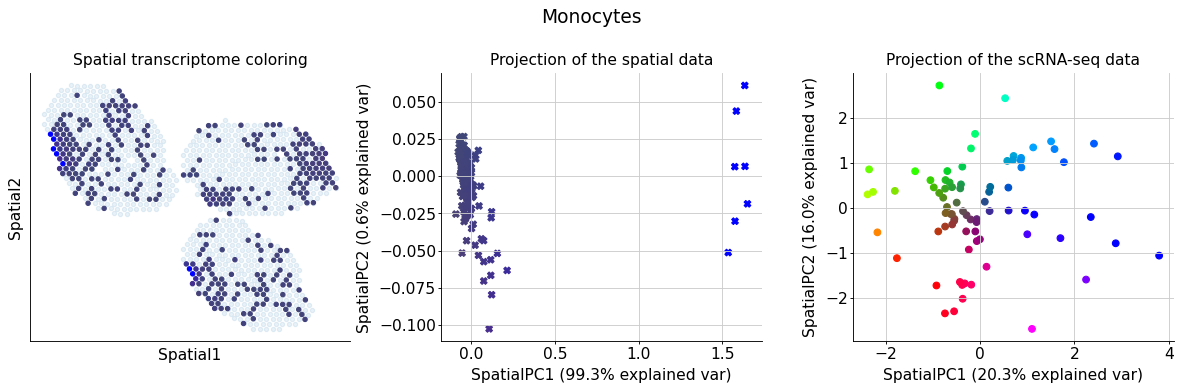



Component:0

top
Pcp4, Ptprm, Cd247, Cd209d, Prg2, Prg4, Cd163l1, Cd160, Prr11, Psd2, Ptpn13, Ccr4, Ptprf, Ptprk, Ccr10, Rgs16, Ccne2, Ccne1, Rad51, Rad54b, Ramp3, Klra9, Ccna2, Rasl11a, Ccl22, Rassf6, Ccl17, Hmmr, Efnb3, Ppp1r3d, Ppp1r14a, Ppic, Cdk1, Cdh2, Cdh1, Phf24, Ighg3, Ighg2b, Cdca3, Igha, Pif1, Igfbp7, Cdc25c, Cdc20, Plagl1, Plat, Dusp4, Plce1, Ifitm10, Plk1

Cyclin A/B1-associated events during G2/M transition, Phosphorylation of Emi1, Oocyte meiosis, G0 and early G1 pathway, MicroRNA regulation of DNA damage response, p73 transcription factor network, FOXM1 transcription factor network, Polo-like kinase 1 (PLK1) pathway, Type I interferon (interferon-alpha/beta) pathway, Binding of chemokines to chemokine receptors

bottom
Cybb, Lsp1, Itgal, Cst3, Plac8, Napsa, Msrb1, Fcer1g, Hp, Mapkapk2, Flna, Ms4a6c, Gpx1, Ccl6, Gpr141, Ms4a6b, Rnase6, Spn, Ace, Ear2, Rassf4, Ifitm3, Anxa2, Tyrobp, Ly6c2, Ms4a4c, Nr4a1, Clec4a3, Actg1, S100a6, Adgre4, Nxpe4, Cebpb, Lrp1, Myo1f, Ncf2, T

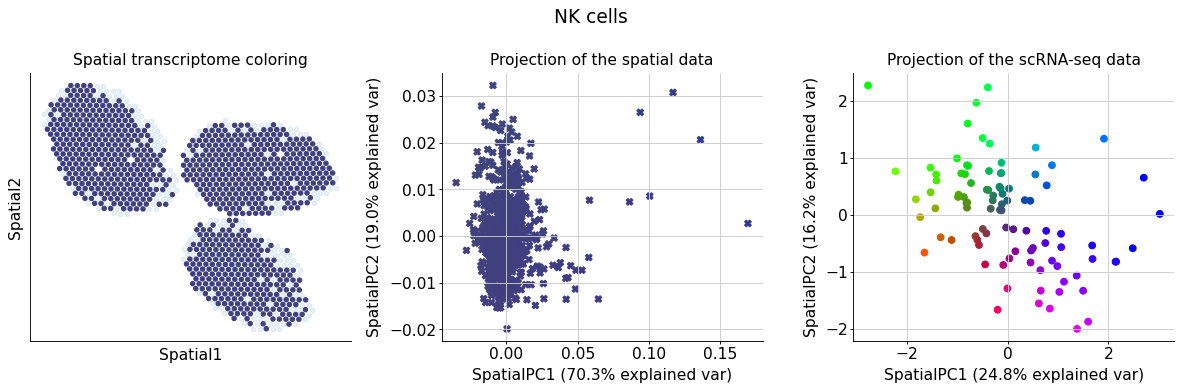



Component:0

top
1300017J02Rik, Pla2g7, Pld4, Dusp4, Plce1, Plcb1, Plbd1, Dusp9, Plat, Plagl1, Pla2g4a, Dst, E2f7, E2f8, Ear2, Ebi3, Pilrb1, Pilra, Pif1, Pid1, Plekhg1, Dqx1, Fabp4, Dnah2, Ddr1, Depdc1b, Derl3, Ppp1r3d, Ppp1r14a, Ppic, Ppfia4, Ppef2, Popdc2, Plpp1, Dnase1l3, Dnm3, Dnph1, Dntt, Plxnd1, Dock4, Plxnb2, Plxna1, Pianp, Pi16, Efna2, Oaf, Esco2, Etv5, P3h2, P2ry6

Hydrolysis of lysophosphatidylcholine (LPC), MAP kinase pathway regulation through dual specificity phosphatases, Acyl chain remodelling of phosphatidylinositol, Inhibition of platelet activation by aspirin, Other semaphorin interactions, PKC-catalyzed phosphorylation of inhibitory phosphoprotein of myosin phosphatase, Axon guidance, Glycerophospholipid biosynthesis, Eicosanoid metabolism, Acyl chain remodelling of phosphatidylcholine

bottom
Eomes, Ctla2a, Ccr2, Gzma, Sh2d1a, Klre1, S100a10, Klra4, Hmgb2, Rpsa, Fcgr3, Klrd1, Ccl5, Rps12, Gm15987, Samd3, Mef2c, Klra7, Klrc2, Dnajb14, H2afz, Myb, Klra8, Rplp0, Klri

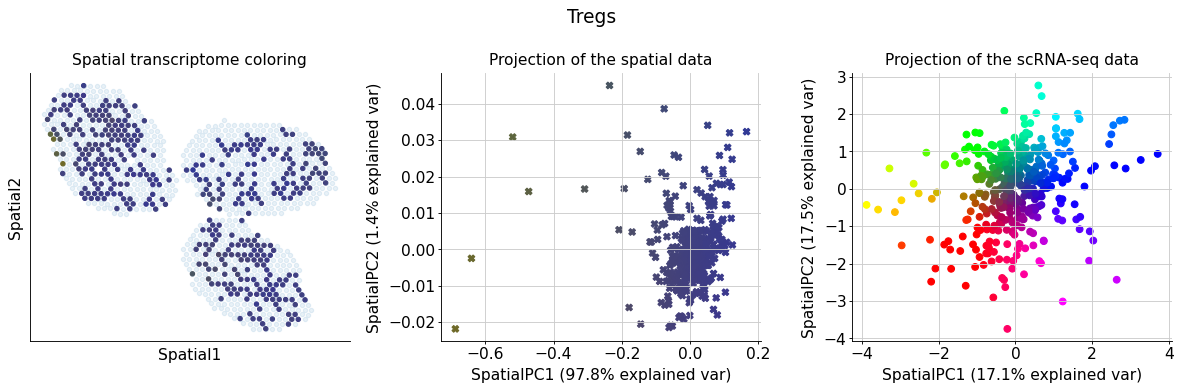



Component:0

top
Chl1, Mgl2, Snx22, Pirb, Pla2g2d, Pla2g4a, Pla2g7, Rassf6, Sox13, Mgst1, Mgll, Mfsd7a, Bcl2a1a, Cd209d, Met, Mertk, Mefv, Spic, Depdc1b, Psd2, Mcemp1, Plat, Mmp19, Mmp23, Cd209a, Pilrb2, Slc7a11, Slc7a7, Slc7a8, Slc8a1, Mycl, Rem1, Cygb, Msr1, Ms4a8a, Ms4a7, Dab2, Dbn1, Smim5, Pilra, Pilrb1, Batf2, Snai1, Mreg, Mrc1, Dnah2, Mab21l3, Plbd1, Ehf, Plekhg1

Acyl chain remodelling of phosphatidylinositol, Hemostasis pathway, Basigin interactions, Acyl chain remodelling of phosphatidylcholine, Amino acid transport across the plasma membrane, Glycerophospholipid biosynthesis, Cell surface interactions at the vascular wall, Ether lipid metabolism, Transport of inorganic cations/anions and amino acids/oligopeptides, Hydrolysis of lysophosphatidylcholine (LPC)

bottom
Ifit3, Rsad2, Cmpk2, Ifit1, Ifit3b, Rtp4, Irf7, Isg15, Oas3, Usp18, Parp14, Zbp1, Slfn5, Isg20, Ddx60, Slfn1, Trim30a, AW112010, Rnf213, Lgals3bp, Gbp4, Gbp7, Herc6, Ms4a4b, Ctla2a, Phf11b, Trafd1, Ahnak, Oasl2, 

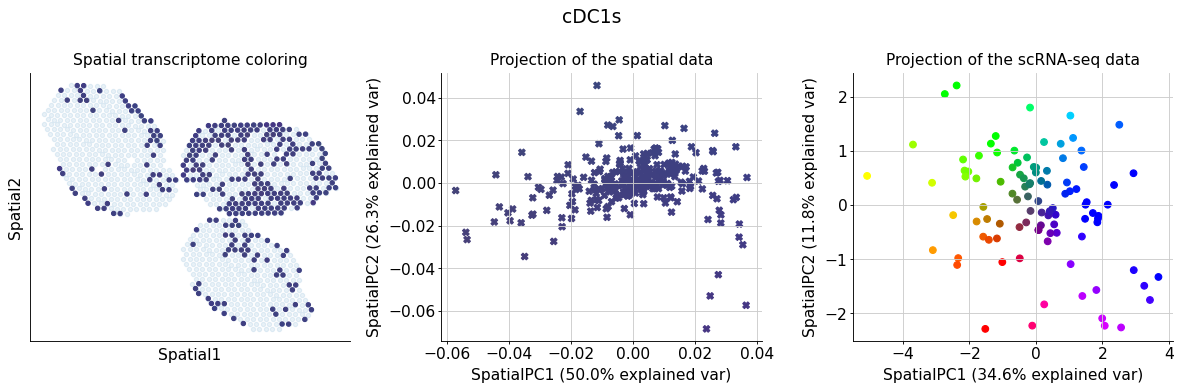



Component:0

top
Nuggc, Plcb1, Lrrc32, Sned1, F13a1, Etl4, Erbb2, Lta, Sox13, Ly6k, Sox5, Eomes, Sparc, Enpp2, Plscr4, Efnb3, Spon1, Dqx1, Dntt, Fabp4, Fads3, Fasl, Lifr, Gas6, Prg2, Prf1, G0s2, Lcn4, Foxp3, Ppp1r3d, Ppic, Lrg1, Lingo4, Lipc, Slfn4, Popdc2, Slpi, Fcgr1, Lmo7, Plekhg1, Dnah2, Chdh, Rai14, Tcrg-C1, Tcrg-C2, Tcrg-C4, Cntnap1, Tdrp, Cmklr1, Cma1

Interleukin-2/STAT5 pathway, Response to elevated platelet cytosolic calcium, Type 1 diabetes mellitus, Lipid digestion, mobilization, and transport, G-protein signaling through tubby proteins, GRB7 events in ERBB2 signaling, CD8/T cell receptor downstream pathway, Myc repressed pathway, Platelet activation, signaling and aggregation, Adherens junction cell adhesion

bottom
S100a4, Fabp5, Ppia, Fscn1, Ptma, Ifitm6, Nrgn, H2afz, Lad1, Gjb2, Aurkb, Nt5dc2, Birc5, Kif2c, Myh10, Ptpn13, Fblim1, Il9r, Atp1b1, Rrm2, Cacnb3, Rem1, Tmem176b, Kif11, Fth1, Clec4a3, Mybl1, Clec4a2, Cited4, Sapcd2, Arhgap19, Ube2c, Sirpb1c, Top2a, Ncaph, Bu

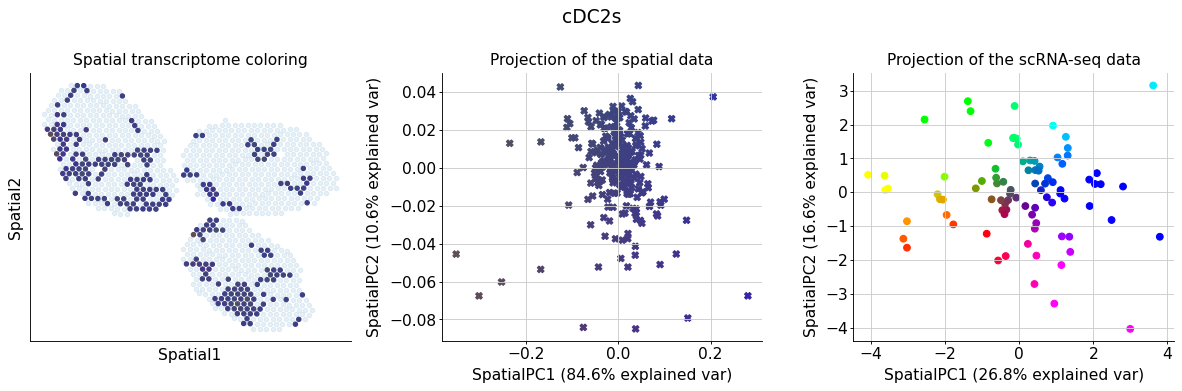



Component:0

top
Map2, Cited4, Rasl11a, Cox4i2, Thbs1, Thbd, Coro2b, Tgm1, Bhlhe41, Klk1, Bpifb3, Klk1b27, Klra1, Cma1, Rgs13, Tcrg-C4, Tcrg-C2, Tcrg-C1, Rgs16, Clec4e, Rhoc, C4b, Rorc, Klra4, Klra6, Mpp2, Klra7, Bcat1, Hba-a1, Hbegf, Khdc1a, Fblim1, Tnnt2, Ncr1, Prg2, Tnfrsf9, Tnfrsf8, Prg4, Hist1h2ag, Igfbp7, Psd2, Ctla2b, Tmem26, Myh10, Ptgs1, Ptpn13, Ptprk, Tlr3, Ptprm, Fcrl5

Type I interferon (interferon-alpha/beta) pathway, Sema4D in semaphorin signaling, G alpha i pathway, Circadian rhythm, Semaphorin interactions, G alpha q pathway, Complement and coagulation cascades, Jak-STAT signaling pathway, Activation of C3 and C5, Cardiac muscle contraction

bottom
Gm42418, Pdlim4, Tgfbi, Myof, Sat1, Pld4, Neat1, Psap, Sirpa, Itgam, Malat1, Gda, Clec4a3, Cd63, Etv5, Fyb, Tspan33, Mpeg1, Mafb, Slc7a8, Pla2g7, Hk3, Slc11a1, Ppt2, Slfn4, Cxcl16, Zeb2, Mmp12, Cd44, Cfb, Arhgef10l, Dnah2, Gpr141, Chil3, St8sia6, Gpsm2, Trps1, Itgax, Nxpe4, Tfec, Htra1, Gsap, Sirpb1c, Cxcl13, Acta2, Pdgfb, 

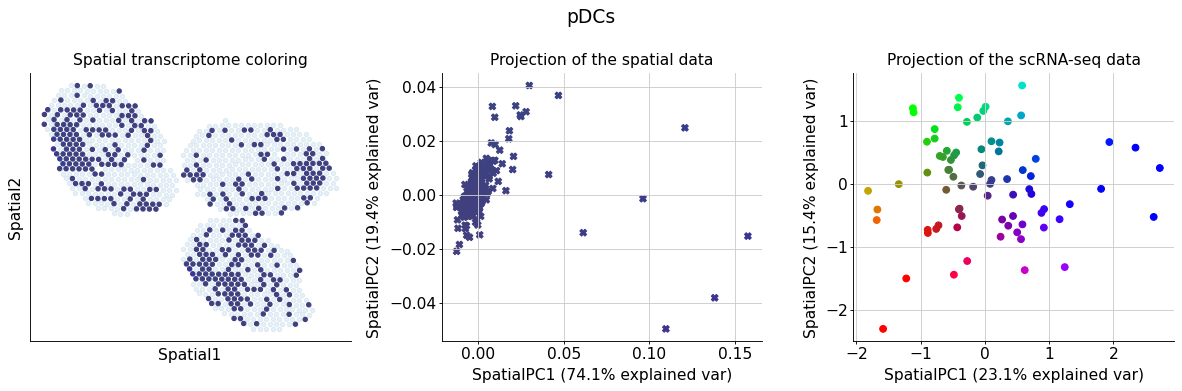



Component:0

top
1300017J02Rik, Ryr3, Mafb, Mab21l3, M1ap, Lyz1, Ltc4s, Ltb4r1, Lsr, Lrrc32, Lrr1, Lrg1, Lockd, Lmo7, Lipc, Lingo4, Lcn4, Lad1, Kntc1, Arhgef40, Klrg1, Arhgef9, Klrc2, Arhgap28, Marco, Mcm10, Mmp23, Mylk, Apol7c, Mxd3, Mt2, Ms4a8a, Mrc1, Aqp9, Mpp2, Mmp25, Mmp19, Arhgap22, Mmp14, Mmp12, Arc, Mgst1, Met, Mertk, Mefv, Arhgap20, Mdk, Klrc1, Klrb1c, Klrb1b

Matrix metalloproteinases, Rho GTPase cycle, Ras-independent pathway in NK cell-mediated cytotoxicity, Activation of matrix metalloproteinases, Adherens junction cell adhesion, Antigen processing and presentation, Sema4D-mediated inhibition of cell attachment and migration, Inhibition of matrix metalloproteinases, Extracellular matrix organization, Passive transport by aquaporins

bottom
Gpx1, Runx2, C1qbp, Hspe1, Gria3, Dntt, Nhp2, Nucb2, Sec61b, Set, Clec10a, Bmp2k, Rpl41, Dtymk, Ywhae, Rplp0, Mzb1, Gm42418, Spns3, Rpsa, Hnrnpa1, Cd24a, Cox6a2, Lsp1, Zfhx3, Nop58, Ramp1, Apex1, Rad51ap1, S100a10, Rassf4, Irf8, Rps2, 

In [54]:
for name_ct in ct_list:
    # show proportions
    print("\n" + name_ct + " ANALYSIS:")
    # find the components
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][[name_ct]].values[filter_]
    ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
    data = gamma[:, :, ct_index][filter_]
    vec = get_spatial_components(locations, proportions, data)
    # project data onto them
    projection = np.dot(data - np.mean(data, 0), vec)

    # create the colormap
    cmap = cmap2d.TernaryColorMap(tri_coords, tri_colors)

    # apply colormap to spatial data
    color = np.vstack([cmap(projection[i]) for i in range(projection.shape[0])])
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(name_ct)
    ax1 = plt.subplot(132)
    prettify_axis(ax1)
    plt.scatter(projection[:, 0], projection[:, 1],c=color, marker="X")
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(data.T)))
    explained_var = 100 * np.diag(np.cov(projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the spatial data")

    ax3 = plt.subplot(131)
    prettify_axis(ax3, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=15)
    plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
                c=color, s=15)
    plt.title("Spatial transcriptome coloring")

    # go back to the single-cell data and find gene correlated with the axis
    sc_data_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
    normalized_counts = sc_data_slice.X.A
    sc_latent = sc_data_slice.obsm["X_CondSCVI"]
    sc_projection = np.dot(sc_latent - np.mean(sc_latent,0), vec)

    # show the colormap for single-cell data
    color = np.vstack([cmap(sc_projection[i]) for i in range(sc_projection.shape[0])])
    ax2 = plt.subplot(133)
    prettify_axis(ax2)
    plt.scatter(sc_projection[:, 0], sc_projection[:, 1],c=color)
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(sc_latent.T)))
    explained_var = 100 * np.diag(np.cov(sc_projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the scRNA-seq data")
    plt.tight_layout()
    plt.show()

    # calculate correlations, and for each axis: (A) display top 50 genes + AND - (B) for each gene set, get GSEA 
    for d in [0, 1]:
        print("\n")
        print("Component:" + str(d))
        r = vcorrcoef(normalized_counts.T, sc_projection[:, d])
        for mode in ["top", "bottom"]:
            print("\n" + mode)
            ranking = np.argsort(r)
            if mode == "top":
                ranking = ranking[::-1]
            gl = list(st_adata.var.index[ranking[:50]])
            print(", ".join(gl) + "\n")
            enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
            print(", ".join(enr.results.head(10)["Term"].values))


### Last piece of automated analysis, look for Hotspot modules in the imputed values

In [58]:
#fix a cell type
for name_ct in ct_list:
    # show proportions
    print("\n" + name_ct + " ANALYSIS:")

    # get data
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][[name_ct]].values[filter_]

    # impute
    imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

    # run hotspot
    loc = pd.DataFrame(data=locations, index=st_adata.obs.index[filter_])
    df = pd.DataFrame(data=imp_ge.T, 
                      columns=st_adata.obs.index[filter_], index=st_adata.var.index)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=5,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)

    gl = list(hs_results.index[:50])
    print(", ".join(gl) + "\n")
    enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
    print(", ".join(enr.results.head(10)["Term"].values))

100%|██████████| 1888/1888 [00:00<00:00, 42351.07it/s]


B cells ANALYSIS:
Cd74, Igkc, Tmsb4x, Ighm, H2-Ab1, Rps12, Rpl41, H2-Aa, Cd79a, H2-Eb1, Actb, Rplp1, Iglc2, Fth1, Iglc3, Rpsa, Ly6d, Ppia, Rps2, Actg1, Ifi27l2a, Hspa8, B2m, Ptma, Ly6a, Fcer2a, Fcmr, Unc93b1, Ms4a1, Rplp0, Iglc1, Ftl1, Rnf213, Hsp90ab1, Crip1, Swap70, Cr2, Icosl, Malat1, Neat1, H2-DMb1, Irf8, Lsp1, Gapdh, Hspe1, Eif5a, Eif4a1, Ctsh, Wdfy4, Blk




100%|██████████| 1888/1888 [00:00<00:00, 30702.60it/s]

Antigen-activated B-cell receptor generation of second messengers, Translation, Signaling by the B cell receptor (BCR), Immune system, Cytoplasmic ribosomal proteins, Influenza viral RNA transcription and replication, Protein metabolism, Influenza infection, Adaptive immune system, Immunoregulatory interactions between a lymphoid and a non-lymphoid cell

CD4 T cells ANALYSIS:
Tmsb4x, Ifi27l2a, Rplp1, Rpl41, Actb, Rps12, Rpsa, Trbc2, Trbc1, B2m, Ms4a4b, Irf7, Rplp0, Stat1, Ppia, Rps2, Fth1, Igtp, Rnf213, Lat, Hspa8, Ly6a, Ms4a6b, Slfn1, Trac, Ifit3, Actg1, Zbp1, Gbp4, Ifi47, Ptma, Bst2, Trim30a, Ighm, Isg15, Lck, Cd3d, Rtp4, Pkm, Itm2b, Crip1, Usp18, Dapl1, Parp14, Npm1, Npc2, Ftl1, Psap, Iigp1, Gm42418




100%|██████████| 1888/1888 [00:00<00:00, 20590.14it/s]

Disease, Generation of second messenger molecules, Immune system, Interferon signaling, Cytoplasmic ribosomal proteins, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Interferon alpha/beta signaling, Influenza viral RNA transcription and replication, PD-1 signaling, Influenza infection

CD8 T cells ANALYSIS:
Tmsb4x, Rplp1, Rpl41, Actb, Rps12, Rpsa, Trbc2, Ppia, Trbc1, Rps2, Rplp0, B2m, Actg1, Lat, Ifi27l2a, Hspa8, Ms4a4b, Cd8a, Trac, Fth1, Thy1, Ptma, Lck, Ighm, Cd8b1, Eif4a1, Cd3d, Tubb5, Cd3g, Npm1, Ms4a6b, Crip1, Ftl1, Eif5a, Hspe1, Npc2, Hsp90ab1, Nme2, Stat1, Gm42418, Gapdh, Ldha, Ctsw, Rnf213, Cd3e, Malat1, Itm2b, Neat1, Psap, Pkm




100%|██████████| 1888/1888 [00:00<00:00, 22905.51it/s]

Generation of second messenger molecules, T cell receptor signaling in naive CD8+ T cells, T helper cell surface molecules, PD-1 signaling, Interleukin-12-mediated signaling events, Disease, Immunoregulatory interactions between a lymphoid and a non-lymphoid cell, CTL mediated immune response against target cells, Lck and Fyn tyrosine kinases in initiation of T cell receptor activation, MEF2D role in T cell apoptosis

GD T cells ANALYSIS:
Tmsb4x, Rps12, Rplp1, Crip1, Rpl41, Actb, Actg1, S100a6, Hspa8, Ppia, Itm2b, B2m, 5830411N06Rik, Fth1, Thy1, Il7r, Vim, Rps2, Cd163l1, Lat, Ly6a, Trdc, S100a4, Rpsa, S100a10, Trbc1, Rplp0, Blk, Capg, Trbc2, Ftl1, Nme2, Psap, Lsp1, Tmem176a, Tmem176b, Lgals3bp, Lgals1, Anxa6, Cd3g, Pxdc1, Txn1, Npm1, Adam8, AW112010, Irf7, Itgal, Ptma, Gapdh, Hsp90ab1




100%|██████████| 1888/1888 [00:00<00:00, 34722.49it/s]

T cell receptor regulation of apoptosis, Cytoplasmic ribosomal proteins, Disease, Influenza viral RNA transcription and replication, Influenza infection, Translation, CTL mediated immune response against target cells, T helper cell surface molecules, Prostaglandin biosynthesis and regulation, Generation of second messenger molecules

Macrophages ANALYSIS:
Tmsb4x, Lyz2, Fth1, C3, Ftl1, Ccl21a, Rpl41, Rps12, Rplp1, Actb, Cxcl9, Gpx1, Ifitm3, Ppia, Marco, Rpsa, Rps2, Cfb, Cd63, C1qb, Rplp0, Cxcl10, Gapdh, Cox5a, Vim, Actg1, Hspa8, C1qa, Aif1, Cd209b, Cd74, Ccl8, Fabp5, Nme2, Apoe, Irf7, Txn1, Gngt2, Atox1, B2m, Tyrobp, Psap, Bst2, Itm2b, Ighm, Sec61b, Igkc, Crip1, Cxcl12, C1qc




100%|██████████| 1888/1888 [00:00<00:00, 23878.92it/s]

Complement cascade, Complement activation, classical pathway, Translation, Cytoplasmic ribosomal proteins, Influenza viral RNA transcription and replication, Immune system, Complement and coagulation cascades, Influenza infection, Disease, Protein metabolism

Migratory DCs ANALYSIS:
Ccl21a, Apol7c, Malat1, Neat1, Ccl22, Cacnb3, Clu, Fscn1, Tmsb4x, Il4i1, C4b, Traf1, C3, Icosl, Ccl5, Swap70, Birc2, Tmem123, Myo1g, Rogdi, Gm42418, Actb, Pfkfb3, Anxa3, Synpo2, Nfkbia, Gbp8, Igkc, Tbc1d4, Cd74, Gadd45b, Adcy6, Zmynd15, Slc4a8, Cxcl16, Relb, Poglut1, Arhgap22, Irf1, Id2, Etv3, Psap, Net1, Csf2rb2, Csf2rb, Gbp4, Birc3, Prex1, B2m, Ctsh




100%|██████████| 1888/1888 [00:00<00:00, 29184.43it/s]

TNF-alpha effects on cytokine activity, cell motility, and apoptosis, TWEAK signaling pathway, CD40/CD40L signaling, Interleukin-5 regulation of apoptosis, T cell receptor regulation of apoptosis, Immune system, Chemokine signaling pathway, Keratinocyte differentiation, HIV-1 Nef as negative effector of Fas and TNF, Innate immune system

Monocytes ANALYSIS:
Tmsb4x, Cd74, Psap, Lyz2, C3, H2-Ab1, H2-Eb1, H2-Aa, Ifitm3, Rpl41, B2m, Pld4, Rnf213, Ftl1, Actb, Tgfbi, Fth1, Ly6i, Cfb, Ctss, Rps12, Grn, Gm42418, Irf7, Prkcd, Sirpa, Cxcl10, Gpx1, Unc93b1, Cybb, Tmem176b, Hspa8, Sdc3, C4b, Ifi30, Ly6c2, H2-DMb1, Csf1r, Mpeg1, Ctsb, Axl, Rasa4, Actg1, Tmem176a, Itm2b, Ifi27l2a, Rplp1, Cst3, Stat1, Ccl21a




100%|██████████| 1888/1888 [00:00<00:00, 23950.85it/s]

Antigen processing and presentation, Immune system, Activation of C3 and C5, Disease, Toll-like receptor endosomal trafficking and processing, Interferon signaling, Interferon-gamma signaling pathway, Complement cascade regulation, Type II interferon signaling (interferon-gamma), Amyloids

NK cells ANALYSIS:
Ccl5, Tmsb4x, Ly6c2, AW112010, Actb, Rpl41, Rps12, Klrd1, H2afz, Ctsw, Actg1, B2m, Nkg7, Tyrobp, Il2rb, Itgal, Ms4a4b, Rplp1, Ctla2a, Fcer1g, Itgb2, Ppia, Flna, Crip1, Hspa8, Ahnak, Neat1, Trbc1, Rpsa, Selplg, Zyx, Serpinb9, Gm42418, Xcl1, Fth1, Serpina3g, Lck, Il18rap, Klrk1, Rnf213, Cd7, Itm2b, Ifngr1, Hcst, Trdc, Ighm, Nfkbia, Gzma, Irf8, Rps2




100%|██████████| 1888/1888 [00:00<00:00, 26832.36it/s]

Natural killer cell-mediated cytotoxicity, Immunoregulatory interactions between a lymphoid and a non-lymphoid cell, Interleukin-2 signaling pathway, Immune system, Cell surface interactions at the vascular wall, T cell receptor regulation of apoptosis, Adaptive immune system, Interleukin-12-mediated signaling events, Disease, CTL mediated immune response against target cells

Tregs ANALYSIS:
Tmsb4x, Ifi27l2a, Rpl41, Rplp1, Actb, Trbc1, Trbc2, Stat1, Rpsa, Ppia, B2m, Ms4a4b, Rps12, Tnfrsf4, Hspa8, Foxp3, Il2rb, Rnf213, Usp18, Rps2, Igtp, Ctla4, Fth1, Ms4a6b, Iigp1, Malat1, Rplp0, Izumo1r, Gbp4, Actg1, Ighm, Il2ra, Irf7, Parp14, H2afz, Neat1, Ptma, Trim30a, Irf1, Ifi47, Gm42418, Zbp1, Lat, Psap, Lsp1, Ifit3, Trac, Cd27, Crip1, Hsp90ab1




100%|██████████| 1888/1888 [00:00<00:00, 38167.34it/s]

Immune system, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Interferon signaling, Cytoplasmic ribosomal proteins, Interferon alpha/beta signaling, Disease, Influenza viral RNA transcription and replication, Influenza infection, Translation, Interferon-gamma signaling pathway

cDC1s ANALYSIS:
Tmsb4x, Cd74, H2-Eb1, H2-Aa, H2-Ab1, Fth1, Rpl41, Actb, Lyz2, Rps12, Rplp1, S100a4, Ftl1, Actg1, Fscn1, Atox1, Rpsa, S100a6, Ifitm3, Rplp0, Rps2, H2afz, Gpx1, Lsp1, Ppia, H2-DMb1, B2m, Crip1, Apol7c, Hspa8, Vim, Tmem176b, Ctss, Psap, Dnase1l3, Fabp5, Ifi30, Ifitm2, Fcer1g, Ly6c2, Tyrobp, Syngr2, Ccl5, Hspe1, Gapdh, Sub1, Sec61b, Rogdi, Nme2, Nfkbia




100%|██████████| 1888/1888 [00:00<00:00, 34238.92it/s]

T cell receptor regulation of apoptosis, Translation, Cytoplasmic ribosomal proteins, Influenza viral RNA transcription and replication, Influenza infection, Antigen processing and presentation, Disease, Protein metabolism, Interleukin-2 signaling pathway, Endosomal/vacuolar pathway

cDC2s ANALYSIS:
Ccl21a, Psap, Cd74, H2-Ab1, H2-Eb1, C3, Wdfy4, H2-Aa, Gm42418, Neat1, Ifitm1, Lyz2, Actb, Ifitm3, Tmsb4x, Rnf213, Mpeg1, Fth1, Vim, Pld4, Cxcl9, Rps12, Ciita, Hspa8, Tgfbi, Prkcd, H2-DMb1, Grn, Cybb, Rpl41, Rplp1, Ctss, Ncf1, Ifi27l2a, Rpsa, Unc93b1, Stat1, Trim30a, Actg1, Plbd1, B2m, Gpx1, Nfkbia, Ctsa, Pirb, Crip1, Csf2rb, Icosl, Dnase1l3, Themis2




100%|██████████| 1888/1888 [00:00<00:00, 35312.74it/s]

Immune system, Type II interferon signaling (interferon-gamma), Disease, Antigen processing and presentation, T cell receptor regulation of apoptosis, Phagosome, Interferon signaling, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Adaptive immune system, Leishmaniasis

pDCs ANALYSIS:
Bst2, Ly6c2, Tmsb4x, Fth1, Actb, Rpl41, Rps12, Ppia, Cd74, Ccl21a, Irf8, Rplp1, Ftl1, Tyrobp, Dnajc7, Psap, Pld4, Rpsa, Grn, Cyb561a3, Sec61b, Rps2, Ctsh, Lsp1, H2-Aa, Gm42418, Lgals1, Rplp0, Ly6d, Gpx1, Unc93b1, Ly6a, Plac8, Crip1, Klk1, Iglc3, Actg1, Ptma, Rnase6, Ctsb, B2m, Ighm, Irf7, Mpeg1, Ifi27l2a, Tagln2, Eif5a, Prkcd, Gapdh, H2-Ab1



Translation, Cytoplasmic ribosomal proteins, Influenza viral RNA transcription and replication, Protein metabolism, Influenza infection, Immune system, Disease, T cell receptor regulation of apoptosis, Interferon-gamma signaling pathway, Adaptive immune system


## then, quick API for plotting genes in a given cell type

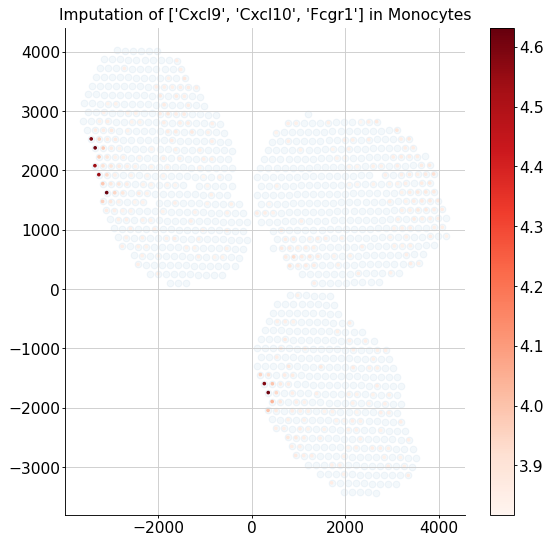

In [64]:
plt.figure(figsize=(8, 8))

name_ct = "Monocytes"
gene_name = ["Cxcl9", "Cxcl10", "Fcgr1"]


# get data
filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
locations = st_adata.obsm["location"][filter_]
proportions = st_adata.obsm["proportions"][[name_ct]].values[filter_]

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {name_ct}")
plt.show()

# Producing figures for the manuscript

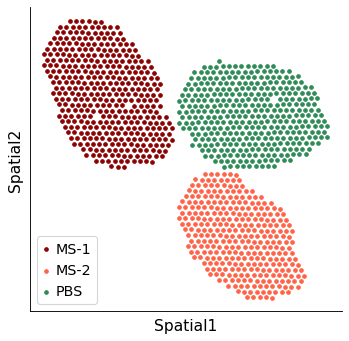

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
color_list = ["darkred", "tomato", "seagreen"]
name_list = ["MS-1", "MS-2", "PBS"]
for i, value in enumerate(["TC", "BD", "TD"]):
    mask = st_adata.obs["LN"] == value
    ax.scatter(st_adata.obsm["location"][mask, 0], st_adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=10)
ax.legend()
prettify_axis(ax, False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Spatial1")
ax.set_ylabel("Spatial2")
plt.show()

##### B cells investigation

First, we identify a hotpot modules on the single-cell data. This can be done on the scLVM or as a standalone analysis (scVI, PCA, etc..). 

In [67]:
# run hotspot
name_ct = "B cells"
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
loc = pd.DataFrame(data=sc_adata_slice.obsm["X_CondSCVI"], index=sc_adata_slice.obs.index)
df = pd.DataFrame(data=sc_adata_slice.X.A.T, columns=sc_adata_slice.obs.index, index=sc_adata_slice.var.index)
# run hotspot
hs = hotspot.Hotspot(df, model='danb', latent=loc,)
hs.create_knn_graph(
        weighted_graph=True, n_neighbors=20,
    )
hs_results = hs.compute_autocorrelations(jobs=1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)



Removing 24 undetected/non-varying genes


100%|██████████| 1864/1864 [00:01<00:00, 1492.06it/s]


In [68]:
hs_genes = hs_results.index[hs_results["FDR"] < 0.0005]
hs_genes

Index(['Ifit3', 'Cd74', 'H2-Aa', 'H2-Eb1', 'Cd79a', 'H2-Ab1', 'Malat1', 'Igkc',
       'Ly6d', 'Mef2c',
       ...
       'Gsap', 'Msmo1', 'Adm', 'Lmo4', 'Cd27', 'P4hb', 'Aqp9', 'Ptger4', 'Ddt',
       'Asph'],
      dtype='object', name='Gene', length=1062)

 28%|██▊       | 300/1062 [00:00<00:00, 2999.60it/s]

Computing pair-wise local correlation on 1062 features...


100%|██████████| 563391/563391 [05:41<00:00, 1651.93it/s]


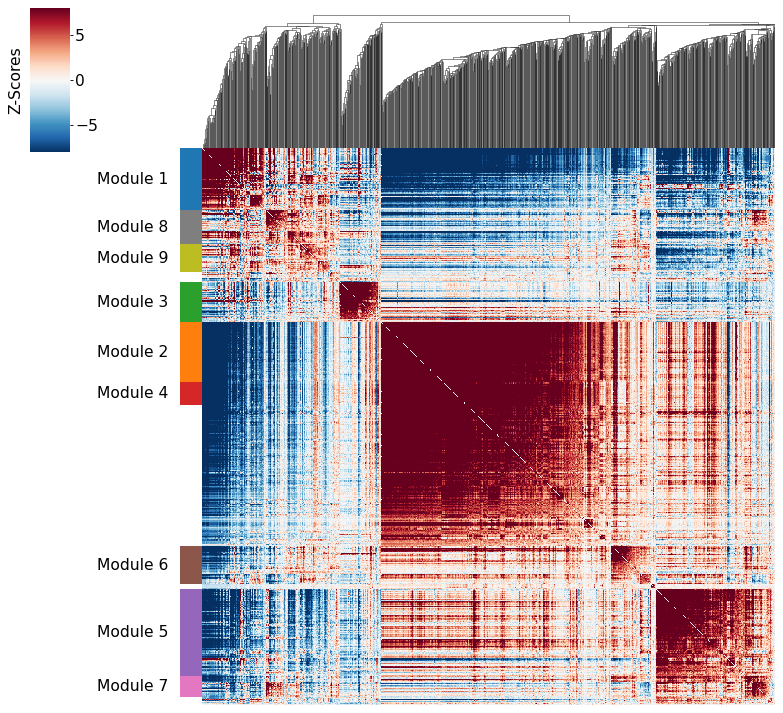

In [69]:
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

modules = hs.create_modules(
    min_gene_threshold=30, core_only=True, fdr_threshold=0.05
)

hs.plot_local_correlations()

In [71]:
hs.modules[["Ifit3", "Ifit1", "Usp18"]]

Gene
Ifit3    3
Ifit1    3
Usp18    3
Name: Module, dtype: int64

In [259]:
len(np.where(hs.modules == 4)[0])

82

In [261]:
gl = list(hs.results.loc[hs.modules.index[np.where(hs.modules == 3)[0]]].index[:50])
print(", ".join(gl) + "\n")
enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
print(", ".join(enr.results.head(10)["Term"].values))

Ifit3, Ifit3b, Usp18, Irf7, Slfn5, Stat1, Rsad2, Ifit1, Ifi47, Rtp4, Ifit2, Zbp1, Isg15, Serpina3g, Ifi27l2a, Oasl2, Plac8, Oas3, Trim30a, Gbp7, Ly6a, Igtp, Bst2, Isg20, Irf1, Parp14, Ms4a4c, Gbp4, Serpina3f, Rnf213, Pkib, Ifitm3, Phf11b, Psmb9, Socs1, Eif2ak2, Cmpk2, Herc6, Sdc3, Lgals3bp, Cybb, Tspo, Gbp2, Trafd1, Hsph1, Phf11a, Sp140, Gbp5, Gbp3, Epsti1

Interferon signaling, Interferon alpha/beta signaling, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Immune system, Interferon-gamma signaling pathway, Type II interferon signaling (interferon-gamma), Antiviral mechanism by interferon-stimulated genes, Interferon alpha signaling regulation, Toll-like receptor signaling pathway regulation, Interferon gamma signaling regulation


In [72]:
name_ct = "B cells"

# STEP1: extract relevant data
# spatial data
threshold_ = 0.2
proportions = st_adata.obsm["proportions"][name_ct].values
filter_ = proportions > threshold_
proportions = proportions[filter_]
index = st_adata.obs.index[filter_]
locations = st_adata.obsm["location"][filter_]
ln_label = st_adata.obs["LN"][filter_]
ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
data = gamma[:, :, ct_index][filter_]
# single cell data
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
normalized_counts = sc_adata_slice.X
sc_latent = sc_adata_slice.obsm["X_CondSCVI"]

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [77]:
result.shape

(8359, 2)

In [73]:
#STEP: embed sc data
dim_red = umap.UMAP(n_neighbors=50)
result = dim_red.fit_transform(sc_adata_slice.obsm["X_CondSCVI"])

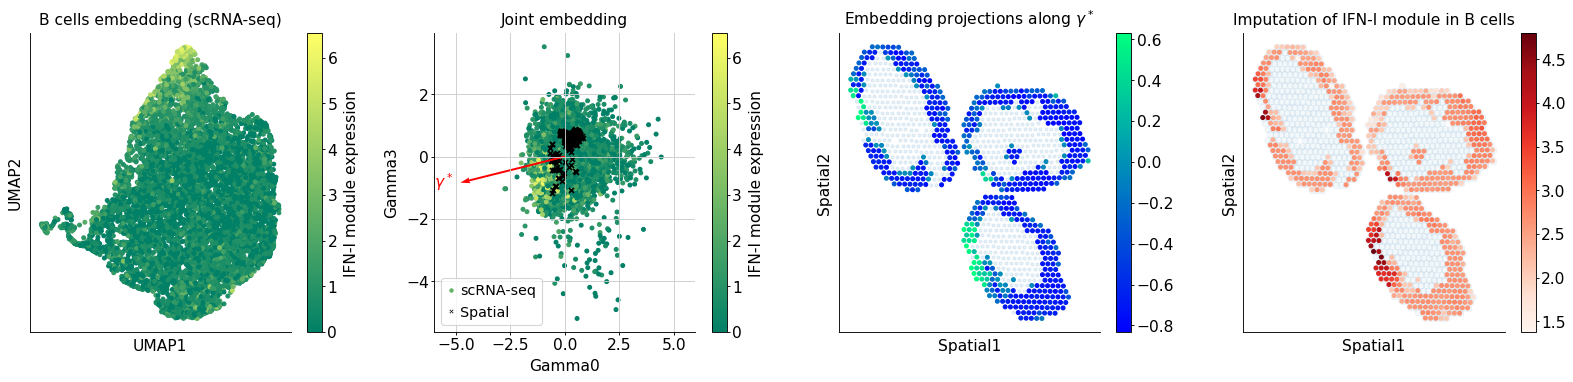

In [78]:
fig = plt.figure(figsize=(20, 5))

gene_name = ['Ifit3', 'Ifit3b', 'Stat1', 'Ifit1', 'Usp18', 'Isg15']
gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]


# ax1: B cells transcriptome with IFIT3
ax1 = plt.subplot(141)
prettify_axis(ax1, False)
plt.scatter(result[:, 0], result[:, 1], c=np.mean(sc_adata_slice.X[:, gene_idx].A, 1), s=12, cmap="summer")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title(f"{name_ct} embedding (scRNA-seq)")
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label("IFN-I module expression")

# joint embedding and selection of gamma star
ax2 = plt.subplot(142)
prettify_axis(ax2, False)
ind_xx = 0
ind_yy = 3
plt.scatter(sc_latent[:, ind_xx], sc_latent[:, ind_yy], c = np.mean(normalized_counts[:, gene_idx].A, 1), 
            s=12, cmap="summer")
cbar = plt.colorbar()
cbar.set_label("IFN-I module expression")
plt.scatter(data[:, ind_xx], data[:, ind_yy], marker="x", s=20, c="black")#, fill=False, alpha=0.5, cmap="autumn")
origin = [0, 0]
handles = [Line2D([0], [0], marker='o', color='w', label='scRNA-seq',
                        markerfacecolor=plt.cm.summer(100), markersize=5),
            Line2D([0], [0], marker='X', color='w', label='Spatial',
                        markerfacecolor="black", markersize=5)]
plt.legend(handles=handles, frameon=True)
star_gamma = np.array([-2, -0.5])
plt.xlim((-6, 6))
origin = [0, 0]
plt.quiver(*origin, star_gamma[[0]], star_gamma[[1]], color=['r'], scale=5)
plt.text( star_gamma[[0]] - 4,  star_gamma[[0]] + 1, r"$\gamma^*$", color="r")
plt.xlabel("Gamma0")
plt.ylabel("Gamma3")
plt.title("Joint embedding")

# visualization of gamma star on spatial
ax3 = plt.subplot(143)
prettify_axis(ax3)
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=8)
color = (star_gamma[0] * data[:, ind_xx] + star_gamma[1] * data[:, ind_yy])/ np.sqrt(sum(star_gamma**2))
vmin = np.quantile(color, 0.01)
vmax = np.quantile(color, 0.99)
plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
            c=color, s=12, vmin=vmin, vmax=vmax, cmap="winter")
plt.title(f"Embedding projections along $\gamma^*$")
plt.colorbar()
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(144)
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of IFN-I module in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

plt.tight_layout()
plt.savefig("figures/B_cells_invest.pdf")


In [80]:
# impute 
imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

# get statistics
avg_library_size = np.mean(np.sum(st_adata.layers["counts"], axis=1).A.flatten())
exp_px_o = st_model.module.px_o.detach().exp().cpu().numpy()
mean = avg_library_size * imp_ge

# create distribution
concentration = torch.tensor(avg_library_size * imp_ge / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

# slice conditions
mask_ms = np.logical_or(ln_label == "TC", ln_label == "BD").values
mask_pbs = (ln_label == "TD").values

# generate
N = 8
simulated_case = Gamma(concentration=concentration[mask_ms], rate = rate).sample((N,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration[mask_pbs], rate = rate).sample((N,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

In [82]:
# differential expression

de_ks =np.array([ks_2samp(simulated_case[:, gene], 
                       simulated_control[:, gene], 
                       alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])
# de_t_test =np.array([ttest_ind(simulated_case[:, gene], 
#                        simulated_control[:, gene], 
#                        alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])

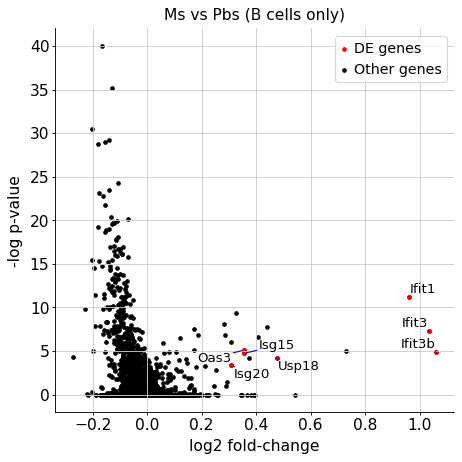

In [84]:
de = de_ks
max_pval = np.max(de[multipletests(de, method='fdr_bh')[0]])
lfc = np.log2(mean[mask_ms].mean(0)) - np.log2(mean[mask_pbs].mean(0))
plt.figure(figsize=(6, 6))
# plot DE genes
mask = (de < max_pval) * (np.abs(lfc) > 0.5)
de_scatter = plt.scatter(lfc[mask], np.clip(-np.log(de[mask]), 0, 40), s=10, c="r")
nde_scatter = plt.scatter(lfc[~mask], np.clip(-np.log(de[~mask]), 0, 40), s=10, c="black")
plt.xlabel("log2 fold-change")
plt.ylabel("-log p-value")

plt.legend((de_scatter, nde_scatter), ("DE genes", "Other genes"), frameon=True)

interesting_genes = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]
texts = []
for i, gene in enumerate(interesting_genes):
    ind = np.where(st_adata.var.index == gene)[0]
    x_coord, y_coord = lfc[ind], -np.log(de)[ind]
    plt.scatter(x_coord, y_coord, c="r", s=10)
    texts += [plt.text(x_coord, y_coord, gene, fontsize=12)]
adjust_text(texts, lfc, -np.log(de), arrowprops=dict(arrowstyle="-", color='blue'))
plt.title("Ms vs Pbs (B cells only)")
plt.tight_layout()
plt.savefig("figures/volcano_B_cells.pdf", dpi=DPI)

In [85]:
print("Ms enriched: " + ", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < max_pval ))[0]].values))
print("Pbs enriched: " + ", ".join(st_adata.var.index[np.where((lfc < -0.5) * (de < max_pval ))[0]].values))

Ms enriched: Ifit1, Ifit3
Pbs enriched: 


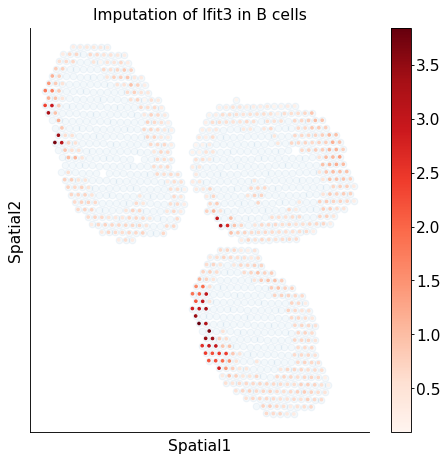

In [91]:
plt.figure(figsize=(6, 6))

name_ct = "B cells"
gene_name = ["Ifit3"]


# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name[0]} in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/B_cells_IFIT.pdf")

#### Monocytes investigation
First, we identify a hotpot modules on the single-cell data. This can be done on the scLVM or as a standalone analysis (scVI, PCA, etc..). 

In [92]:
# run hotspot
name_ct = "Monocytes"
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
loc = pd.DataFrame(data=sc_adata_slice.obsm["X_CondSCVI"], index=sc_adata_slice.obs.index)
df = pd.DataFrame(data=sc_adata_slice.X.A.T, columns=sc_adata_slice.obs.index, index=sc_adata_slice.var.index)
# run hotspot
hs = hotspot.Hotspot(df, model='danb', latent=loc,)
hs.create_knn_graph(
        weighted_graph=False, n_neighbors=5,
    )
hs_results = hs.compute_autocorrelations(jobs=1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 1579/1579 [00:00<00:00, 11280.18it/s]


Removing 309 undetected/non-varying genes


In [93]:
hs_genes = hs_results.index[hs_results["FDR"] < 0.05]
hs_genes

Index(['Dnase1l3', 'Hp', 'H2-Eb1', 'H2-Aa', 'Ace', 'Vcam1', 'Fabp4', 'Fn1',
       'Cxcl9', 'H2-Ab1',
       ...
       'Siva1', 'Sfxn1', 'Tns1', 'Ms4a6d', 'Cd83', 'Gjb2', 'Adora2a', 'C1qbp',
       'Csf1', 'Ctsd'],
      dtype='object', name='Gene', length=321)

100%|██████████| 321/321 [00:00<00:00, 9304.44it/s]

Computing pair-wise local correlation on 321 features...



100%|██████████| 51360/51360 [00:06<00:00, 7995.20it/s] 


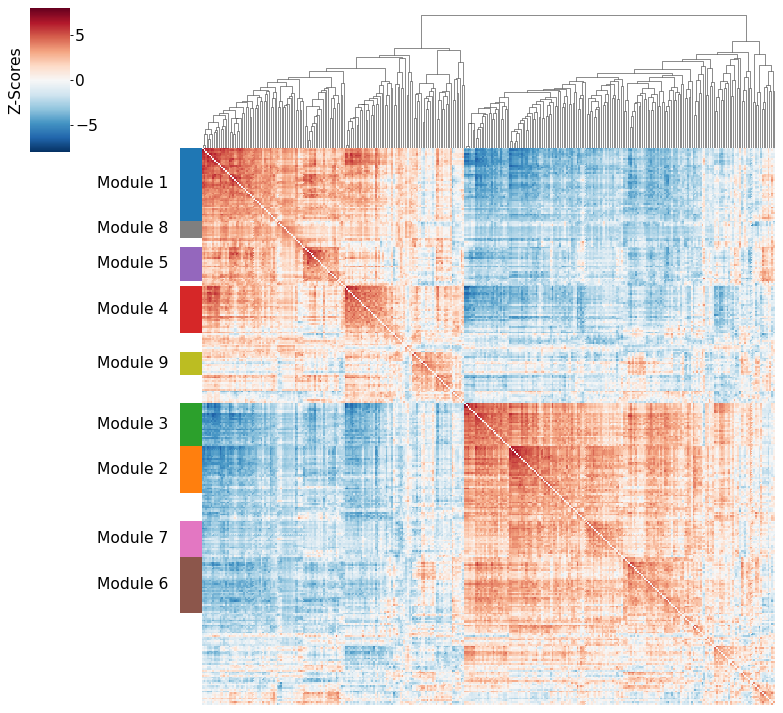

In [96]:
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

modules = hs.create_modules(
    min_gene_threshold=10, core_only=True, fdr_threshold=0.05
)

hs.plot_local_correlations()

In [97]:
hs.modules[["Cxcl10", "Fcgr1", "Isg15"]]

Gene
Cxcl10    9
Fcgr1     9
Isg15     9
Name: Module, dtype: int64

In [305]:
len(np.where(hs.modules == 9)[0])

20

In [304]:
gl = list(hs.results.loc[hs.modules.index[np.where(hs.modules == 9)[0]]].index[:50])
print(", ".join(gl) + "\n")
enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
print(", ".join(enr.results.head(10)["Term"].values))

Ifi47, Cxcl10, Cd36, Gbp5, Clec4e, Fcgr1, Gbp7, Isg15, Igtp, Ifi204, Socs1, Ifi205, Fgl2, Fcgr4, Gbp3, Clic4, Trim30a, Dok2, Snx10, Oasl2

Interferon signaling, Interferon-gamma signaling pathway, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Type II interferon signaling (interferon-gamma), Immune system, Interferon alpha/beta signaling, RIG-I-like receptor signaling pathway, Interleukin-4 signaling pathway, Cross-presentation of particulate exogenous antigens (phagosomes), TSP1-induced apoptosis in microvascular endothelial cell


In [99]:
name_ct = "Monocytes"

# STEP1: extract relevant data
# spatial data
threshold_ = 0.03
proportions = st_adata.obsm["proportions"][name_ct].values
filter_ = proportions > threshold_
proportions = proportions[filter_]
index = st_adata.obs.index[filter_]
locations = st_adata.obsm["location"][filter_]
ln_label = st_adata.obs["LN"][filter_]
ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
data = gamma[:, :, ct_index][filter_]
# single cell data
sc_data_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
normalized_counts = sc_adata_slice.X
sc_latent = sc_adata_slice.obsm["X_CondSCVI"]

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [101]:
#STEP: embed sc data
from sklearn.decomposition import SparsePCA
dim_red = SparsePCA(n_components=2)
result = dim_red.fit_transform(sc_data_slice.X.A)

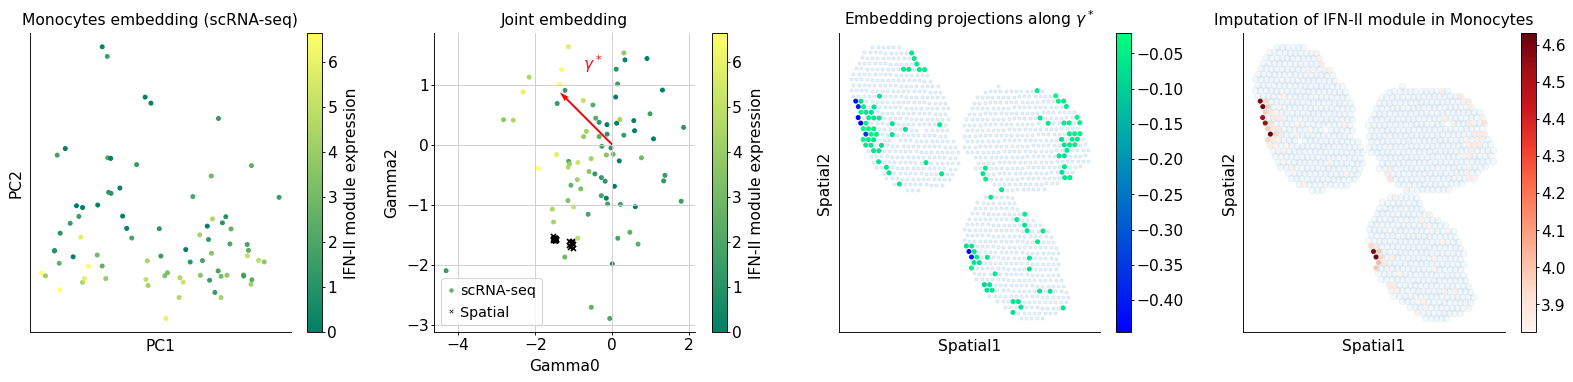

In [102]:
fig = plt.figure(figsize=(20, 5))

gene_name = ['Cxcl10', 'Cxcl9', 'Fcgr1']
gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]


# ax1: B cells transcriptome with IFIT3
ax1 = plt.subplot(141)
prettify_axis(ax1, False)
plt.scatter(result[:, 0], result[:, 1], c=np.mean(sc_adata_slice.X[:, gene_idx].A, 1), s=12, cmap="summer")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{name_ct} embedding (scRNA-seq)")
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label("IFN-II module expression")

# joint embedding and selection of gamma star
ax2 = plt.subplot(142)
prettify_axis(ax2, False)
ind_xx = 0
ind_yy = 3
plt.scatter(sc_latent[:, ind_xx], sc_latent[:, ind_yy], c = np.mean(normalized_counts[:, gene_idx].A, 1), 
            s=12, cmap="summer")
cbar = plt.colorbar()
cbar.set_label("IFN-II module expression")
plt.scatter(data[:, ind_xx], data[:, ind_yy], marker="x", s=20, c="black")#, fill=False, alpha=0.5, cmap="autumn")
origin = [0, 0]
handles = [Line2D([0], [0], marker='o', color='w', label='scRNA-seq',
                        markerfacecolor=plt.cm.summer(100), markersize=5),
            Line2D([0], [0], marker='X', color='w', label='Spatial',
                        markerfacecolor="black", markersize=5)]
plt.legend(handles=handles, frameon=True)
star_gamma = np.array([-1, 1])
origin = [0, 0]
plt.quiver(*origin, star_gamma[[0]], star_gamma[[1]], color=['r'], scale=5)
plt.text( star_gamma[[0]] +0.25,  star_gamma[[0]] + 2.25, r"$\gamma^*$", color="r")
plt.xlabel("Gamma0")
plt.ylabel("Gamma2")
plt.title("Joint embedding")

# visualization of gamma star on spatial
ax3 = plt.subplot(143)
prettify_axis(ax3)
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=8)
color = (star_gamma[0] * data[:, ind_xx] + star_gamma[1] * data[:, ind_yy])/ np.sqrt(sum(star_gamma**2))
vmin = np.quantile(color, 0.01)
vmax = np.quantile(color, 0.99)
plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
            c=color, s=12, vmin=vmin, vmax=vmax, cmap="winter")
plt.title(f"Embedding projections along $\gamma^*$")
plt.colorbar()
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(144)
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of IFN-II module in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

plt.tight_layout()
plt.savefig("figures/Monocytes_invest.pdf")

In [104]:
# impute 
imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

# get statistics
avg_library_size = np.mean(np.sum(st_adata.layers["counts"], axis=1).A.flatten())
exp_px_o = st_model.module.px_o.detach().exp().cpu().numpy()
mean = avg_library_size * imp_ge

# create distribution
concentration = torch.tensor(avg_library_size * imp_ge / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

# slice conditions
mask_ms = np.logical_and(np.logical_or(ln_label == "TC", ln_label == "BD").values, proportions > 0.04)
mask_pbs = (ln_label == "TD").values

print(np.sum(mask_ms), np.sum(mask_pbs))

# generate 
N = 45
simulated_case = Gamma(concentration=concentration[mask_ms], rate = rate).sample((N,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration[mask_pbs], rate = rate).sample((N,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

43 31


In [105]:
from scipy.stats import ttest_ind
# differential expression

de_ks =np.array([ks_2samp(simulated_case[:, gene], 
                       simulated_control[:, gene], 
                       alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])
# de_t_test =np.array([ttest_ind(simulated_case[:, gene], 
#                        simulated_control[:, gene], 
#                        alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])


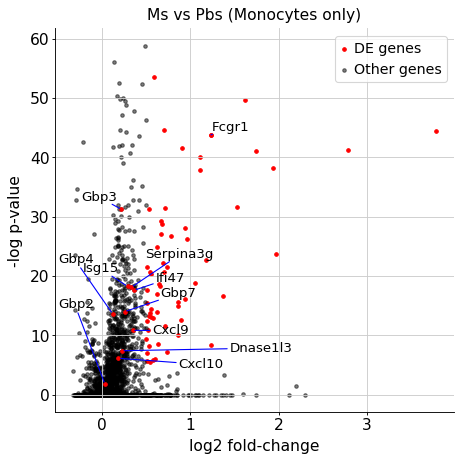

In [108]:
de = de_ks
max_pval = np.max(de[multipletests(de, method='fdr_bh')[0]])
lfc = np.log2(mean[mask_ms].mean(0)) - np.log2(mean[mask_pbs].mean(0))
plt.figure(figsize=(6, 6))
# plot DE genes
mask = (de < max_pval) * (np.abs(lfc) > 0.5)
de_scatter = plt.scatter(lfc[mask], np.clip(-np.log(de[mask]), 0, 200), s=10, c="r")
nde_scatter = plt.scatter(lfc[~mask], np.clip(-np.log(de[~mask]), 0, 200), s=10, c="black", alpha=0.5)
plt.xlabel("log2 fold-change")
plt.ylabel("-log p-value")

plt.legend((de_scatter, nde_scatter), ("DE genes", "Other genes"), frameon=True)

interesting_genes = ["Cxcl9", "Cxcl10", 'Ifi47',
                     'Gbp2', 'Gbp3', 'Gbp4', 'Gbp7',
                     "Serpina3g", "Fcgr1", "Isg15", "Dnase1l3"]
texts = []
for i, gene in enumerate(interesting_genes):
    ind = np.where(st_adata.var.index == gene)[0]
    x_coord, y_coord = lfc[ind], -np.log(de)[ind]
    plt.scatter(x_coord, y_coord, c="r", s=10)
    texts += [plt.text(x_coord, y_coord, gene, fontsize=12)]
adjust_text(texts, lfc, -np.log(de), arrowprops=dict(arrowstyle="-", color='blue'))
plt.title("Ms vs Pbs (Monocytes only)")
plt.tight_layout()
plt.savefig("figures/volcano_Monocytes.pdf", dpi=DPI)

In [109]:
print("Ms enriched: " + ", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < max_pval ))[0]].values))
print("Pbs enriched: " + ", ".join(st_adata.var.index[np.where((lfc < -0.5) * (de < max_pval ))[0]].values))

Ms enriched: Apoe, Asf1b, C1qa, C1qb, C1qc, Ccl12, Cd24a, Cd33, Cd4, Cd79a, Cd83, Chaf1b, Csrp1, Ctsd, Cxcr3, Dctpp1, Dynll2, Ece1, Fcgr1, Fcgr3, Gpm6b, Gpr162, Hpn, Hsd11b1, Ifi44, Iglc3, Il18bp, Itga9, Kdr, Kif20b, Lgmn, Ly6d, Mafb, Mcm4, Mrc1, Ms4a7, Ms4a8a, Myadm, Pf4, Phyhd1, Pkib, Pou2af1, Ptgs1, Rab3il1, Rfc3, Rrm1, Rrp1b, Scimp, Sct, Sema6d, Serpinf1, Sidt1, Slc7a8, Src, Tbxas1, Tgm1, Timp2, Tipin, Tlr3, Uhrf1
Pbs enriched: 


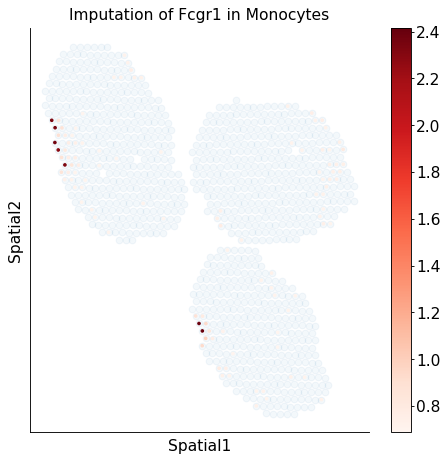

In [111]:
plt.figure(figsize=(6, 6))

name_ct = "Monocytes"
gene_name = ["Fcgr1"]


# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name], 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name[0]} in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/Monocytes_FCGR1.pdf")